# Importing Necessary Libraries

In [1]:
# These are used to handle data laoding directly from Kaggle
import requests
from zipfile import ZipFile
from io import BytesIO

# Preprocessing
import re
import numpy as np
import pandas as pd
from dython.nominal import associations
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Modelling, Predication, and Evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

#Creating Machine learning Pipeline for deployment
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Feature Selection & Feature Engineering
# from sklearn.

#Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Importing Training Data

In [2]:
# URL of the zip file
zip_url = 'https://storage.googleapis.com/kagglesdsdata/competitions/3316/31070/Train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1717275728&Signature=pLbuTQQVCCB%2BTeyugo%2F5ZP%2F0kNqlNmjH6XN5dFNc2W5%2FHhbMVKYCbS%2BHnMumc%2BYSooqbMiflo9UbgNu%2B6qk0ESdKvFxe9XaSUDyKr1bMHexRIuyZ%2BbSmkC4zkrHNcoqpEaJej7AY3FXJIcgOCFv5BDD8T46pNcWFwc4XvjtH8q3u6WMEVY%2Ffwu8c2lBBsWlXWaSGCauxERrj0FeUhfRwG%2FYwaQtFaPPGuvR8rYHR5MycYB8nAs0aqXzreaS4gz4yXsvCZtrz10I%2Bt7u0rg1XUxPa8ZYH%2FYzJyF5ABxTKNn7xTdyxk6wZb8yksmcB09T5Mg9YVmKXdV%2BcX2aiT9%2F5cw%3D%3D&response-content-disposition=attachment%3B+filename%3DTrain.zip'
# Download the zip file
response = requests.get(zip_url)
# Check if the request was successful
if response.status_code == 200:
    # Read the zip file content
    with ZipFile(BytesIO(response.content)) as z:
        # Extract the file names from the zip
        file_list = z.namelist()

        # Assuming there's only one CSV file in the zip archive
        csv_filename = file_list[0]

        # Read the CSV file into a DataFrame
        with z.open(csv_filename) as csv_file:
            df = pd.read_csv(csv_file, low_memory=False, parse_dates=['saledate'])
else:
    print("Failed to download the zip file")

In [3]:
# Set the display format for floating-point numbers
pd.options.display.float_format = '{:,.2f}'.format
df.head()

SalesID  SalePrice  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1139246      66000     999089     3157         121          3.00      2004   
1  1139248      57000     117657       77         121          3.00      1996   
2  1139249      10000     434808     7009         121          3.00      2001   
3  1139251      38500    1026470      332         121          3.00      2001   
4  1139253      11000    1057373    17311         121          3.00      2007   

   MachineHoursCurrentMeter UsageBand   saledate  ... Undercarriage_Pad_Width  \
0                     68.00       Low 2006-11-16  ...                     NaN   
1                  4,640.00       Low 2004-03-26  ...                     NaN   
2                  2,838.00      High 2004-02-26  ...                     NaN   
3                  3,486.00      High 2011-05-19  ...                     NaN   
4                    722.00    Medium 2009-07-23  ...                     NaN   

  Stick_Length Thumb Pattern_Changer Grouser_Type Backhoe_Mounting Blade_Type  \
0          NaN   NaN             NaN          NaN              NaN        NaN   
1          NaN   NaN             NaN          NaN              NaN        NaN   
2          NaN   NaN             NaN          NaN              NaN        NaN   
3          NaN   NaN             NaN          NaN              NaN        NaN   
4          NaN   NaN             NaN          NaN              NaN        NaN   

  Travel_Controls Differential_Type Steering_Controls  
0             NaN          Standard      Conventional  
1             NaN          Standard      Conventional  
2             NaN               NaN               NaN  
3             NaN               NaN               NaN  
4             NaN               NaN               NaN  

[5 rows x 53 columns]

# Exploratory Data Analysis (EDA)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   401125 non-null  int64         
 1   SalePrice                 401125 non-null  int64         
 2   MachineID                 401125 non-null  int64         
 3   ModelID                   401125 non-null  int64         
 4   datasource                401125 non-null  int64         
 5   auctioneerID              380989 non-null  float64       
 6   YearMade                  401125 non-null  int64         
 7   MachineHoursCurrentMeter  142765 non-null  float64       
 8   UsageBand                 69639 non-null   object        
 9   saledate                  401125 non-null  datetime64[ns]
 10  fiModelDesc               401125 non-null  object        
 11  fiBaseModel               401125 non-null  object        
 12  fi

In [5]:
# Checking up on the missing values
df.isna().sum().sort_values(ascending = False)/len(df)*100

Engine_Horsepower          93.71
Pushblock                  93.71
Enclosure_Type             93.71
Blade_Width                93.71
Blade_Extension            93.71
Tip_Control                93.71
Scarifier                  93.71
Grouser_Tracks             89.19
Hydraulics_Flow            89.19
Coupler_System             89.17
fiModelSeries              85.81
Steering_Controls          82.71
Differential_Type          82.70
UsageBand                  82.64
fiModelDescriptor          82.07
Backhoe_Mounting           80.39
Stick                      80.27
Turbocharged               80.27
Pad_Type                   80.27
Blade_Type                 80.10
Travel_Controls            80.10
Tire_Size                  76.39
Track_Type                 75.28
Grouser_Type               75.28
Pattern_Changer            75.27
Stick_Length               75.27
Thumb                      75.25
Undercarriage_Pad_Width    75.10
Ripper                     74.04
Drive_System               73.98
MachineHou

In [6]:
# Many Categorical features have 'None or Unspecified' category that is no different with missing value
df = df.replace('None or Unspecified', np.nan)

## Numeric Attributes

In [7]:
df.describe().T

count                           mean  \
SalesID                  401,125.00                   1,919,712.52   
SalePrice                401,125.00                      31,099.71   
MachineID                401,125.00                   1,217,902.52   
ModelID                  401,125.00                       6,889.70   
datasource               401,125.00                         134.67   
auctioneerID             380,989.00                           6.56   
YearMade                 401,125.00                       1,899.16   
MachineHoursCurrentMeter 142,765.00                       3,457.96   
saledate                     401125  2004-08-02 07:47:13.986413184   

                                          min                  25%  \
SalesID                          1,139,246.00         1,418,371.00   
SalePrice                            4,750.00            14,500.00   
MachineID                                0.00         1,088,697.00   
ModelID                                 28.00             3,259.00   
datasource                             121.00               132.00   
auctioneerID                             0.00                 1.00   
YearMade                             1,000.00             1,985.00   
MachineHoursCurrentMeter                 0.00                 0.00   
saledate                  1989-01-17 00:00:00  2000-10-07 00:00:00   

                                          50%                  75%  \
SalesID                          1,639,422.00         2,242,707.00   
SalePrice                           24,000.00            40,000.00   
MachineID                        1,279,490.00         1,468,067.00   
ModelID                              4,604.00             8,724.00   
datasource                             132.00               136.00   
auctioneerID                             2.00                 4.00   
YearMade                             1,995.00             2,000.00   
MachineHoursCurrentMeter                 0.00             3,025.00   
saledate                  2006-03-23 00:00:00  2009-03-24 00:00:00   

                                          max        std  
SalesID                          6,333,342.00 909,021.49  
SalePrice                          142,000.00  23,036.90  
MachineID                        2,486,330.00 440,991.95  
ModelID                             37,198.00   6,221.78  
datasource                             172.00       8.96  
auctioneerID                            99.00      16.98  
YearMade                             2,013.00     291.80  
MachineHoursCurrentMeter         2,483,300.00  27,590.26  
saledate                  2011-12-30 00:00:00        NaN

In [8]:
df.select_dtypes(['int', 'float']).isna().sum().sort_values(ascending=False)

MachineHoursCurrentMeter    258360
auctioneerID                 20136
SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
YearMade                         0
dtype: int64

In [9]:
cols_to_del = set()
# Determining features that adds no information to the model
for col in df.columns:
  # Columns that have a different value per sample (Unique Identifiers)
  if len(df[col]) == df[col].nunique():
      cols_to_del.add(col)
  # Columns that have the same value for all samples (Static Value)
  elif df[col].nunique == 1:
    cols_to_del.add(col)
print(cols_to_del)

{'SalesID'}


### Inspecting SalePrice (Target Column)

C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


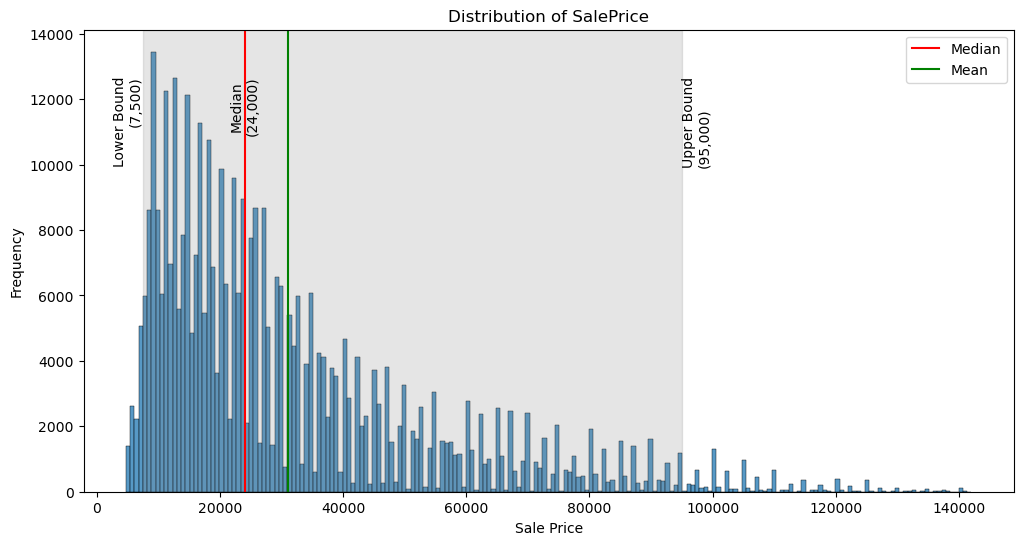

In [10]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate statistics
median_SalePrice = df['SalePrice'].median()
mean_SalePrice = df['SalePrice'].mean()
lower_bound = df['SalePrice'].quantile(0.025)
upper_bound = df['SalePrice'].quantile(0.975)

# Plot histogram
ax = sns.histplot(data=df, x='SalePrice')
ax.axvline(x=median_SalePrice, color='red', linestyle='-', label='Median')
ax.axvline(x=mean_SalePrice, color='green', linestyle='-', label='Mean')
ax.axvspan(lower_bound, upper_bound, alpha= 0.2, color='grey')

# Set labels and title
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of SalePrice')

# 95% confidence interval area 
ax.text(lower_bound, ax.get_ylim()[1]*0.9, f'Lower Bound\n({lower_bound:,.0f})', ha='right', va='top', rotation=90)
ax.text(median_SalePrice, ax.get_ylim()[1]*0.9, f'Median\n({median_SalePrice:,.0f})', ha='center', va='top', rotation=90)
ax.text(upper_bound, ax.get_ylim()[1]*0.9, f'Upper Bound\n({upper_bound:,.0f})', ha='left', va='top', rotation=90)

plt.legend()

plt.show();

### Inspecting MachineID

In [11]:
df.sort_values('MachineID').head(2).T

311936  \
SalesID                                                    2272610   
SalePrice                                                    60000   
MachineID                                                        0   
ModelID                                                         77   
datasource                                                     136   
auctioneerID                                                  1.00   
YearMade                                                      1994   
MachineHoursCurrentMeter                                      0.00   
UsageBand                                                      NaN   
saledate                                       2007-09-25 00:00:00   
fiModelDesc                                                 950FII   
fiBaseModel                                                    950   
fiSecondaryDesc                                                  F   
fiModelSeries                                                   II   
fiModelDescriptor                                              NaN   
ProductSize                                                 Medium   
fiProductClassDesc        Wheel Loader - 150.0 to 175.0 Horsepower   
state                                                     Colorado   
ProductGroup                                                    WL   
ProductGroupDesc                                      Wheel Loader   
Drive_System                                                   NaN   
Enclosure                                               EROPS w AC   
Forks                                                          NaN   
Pad_Type                                                       NaN   
Ride_Control                                                   NaN   
Stick                                                          NaN   
Transmission                                                   NaN   
Turbocharged                                                   NaN   
Blade_Extension                                                NaN   
Blade_Width                                                    NaN   
Enclosure_Type                                                 NaN   
Engine_Horsepower                                              NaN   
Hydraulics                                                 2 Valve   
Pushblock                                                      NaN   
Ripper                                                         NaN   
Scarifier                                                      NaN   
Tip_Control                                                    NaN   
Tire_Size                                                     20.5   
Coupler                                                        NaN   
Coupler_System                                                 NaN   
Grouser_Tracks                                                 NaN   
Hydraulics_Flow                                                NaN   
Track_Type                                                     NaN   
Undercarriage_Pad_Width                                        NaN   
Stick_Length                                                   NaN   
Thumb                                                          NaN   
Pattern_Changer                                                NaN   
Grouser_Type                                                   NaN   
Backhoe_Mounting                                               NaN   
Blade_Type                                                     NaN   
Travel_Controls                                                NaN   
Differential_Type                                         Standard   
Steering_Controls                                     Conventional   

                                                            137897  
SalesID                                                    1497665  
SalePrice                                                    44000  
MachineID                                                        0  
Mod

C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\dython\nominal.py:736: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\dython\nominal.py:737: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)
C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


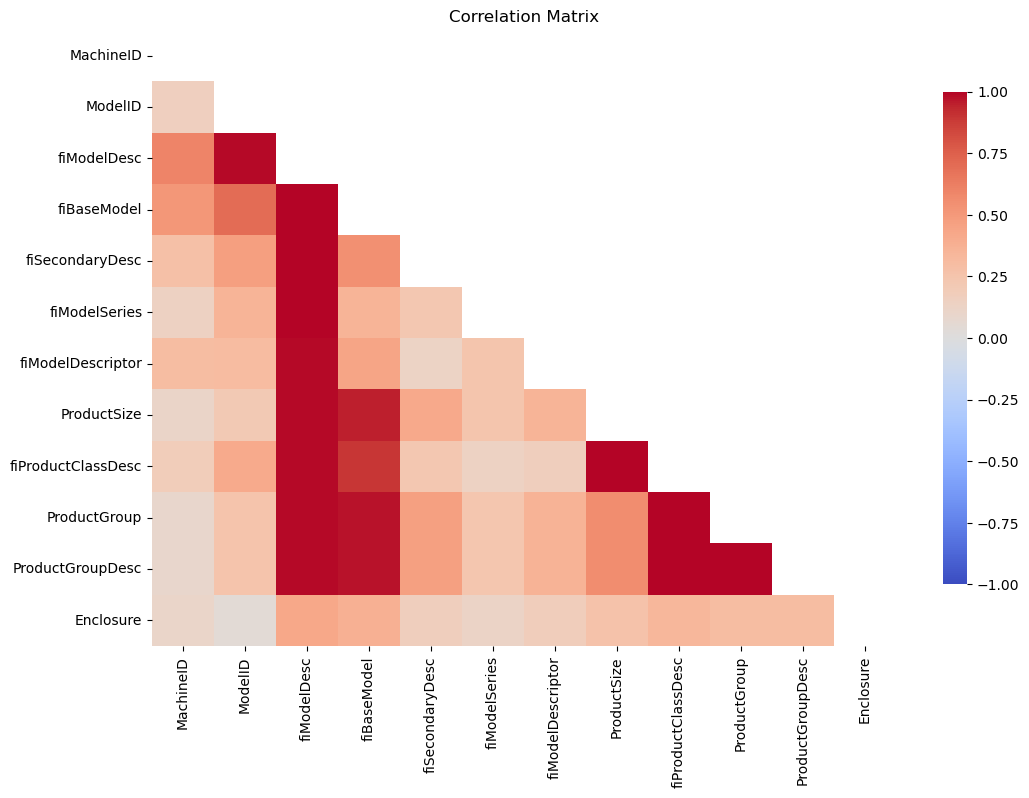

In [12]:
possible_correlated_cols = ['MachineID', 'ModelID', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'ProductGroup', 'ProductGroupDesc', 'Enclosure']
cat_cols = df[possible_correlated_cols].select_dtypes('object').columns.tolist()

# Compute associations between selected columns
assoc = associations(df[possible_correlated_cols], nominal_columns=cat_cols, plot=False)

# Extract the correlation matrix
corr_matrix = assoc['corr']

# Mask the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Plotting
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8}, vmin=-1)
plt.title('Correlation Matrix')
plt.show()

In [13]:
cols_to_del.add('MachineID')

### Inspecting datasource

In [14]:
df.datasource.value_counts(normalize=True).sort_values(ascending=False)

datasource
132   0.65
136   0.19
149   0.07
121   0.06
172   0.04
Name: proportion, dtype: float64

In [15]:
# Compacting the datasources into 3 category
df.datasource = df.datasource.apply(lambda x: x if (x == 132) | (x == 136) else 'Other')

In [16]:
cols_to_cat = set()
cols_to_cat.add('datasource')

### Inspecting auctioneerID

In [17]:
# since auctioneerID has missing values, it should be further investigated prior to making any changes
df.auctioneerID.unique()

array([ 3.,  1.,  2., 11.,  4.,  7., 99.,  6.,  5., 18., 17., 22., 20.,
       14., 16., 21.,  9., 13., 12., 23., 10., 15., 19.,  8., 28., 25.,
       27., 24., nan,  0., 26.])

In [18]:
print(f"Mode of Auctionner ID: {df.auctioneerID.mode()[0]}")
print(f"Median of Auctioneer ID: {df.auctioneerID.median()}")

Mode of Auctionner ID: 1.0
Median of Auctioneer ID: 2.0


In [19]:
df.auctioneerID.value_counts(normalize=True, dropna=False).sort_values(ascending=False)

auctioneerID
1.00    0.46
2.00    0.14
3.00    0.07
4.00    0.05
NaN     0.05
6.00    0.03
99.00   0.03
7.00    0.02
8.00    0.02
5.00    0.02
10.00   0.01
9.00    0.01
11.00   0.01
12.00   0.01
13.00   0.01
18.00   0.01
14.00   0.01
20.00   0.01
19.00   0.01
16.00   0.00
15.00   0.00
21.00   0.00
22.00   0.00
24.00   0.00
23.00   0.00
17.00   0.00
27.00   0.00
25.00   0.00
28.00   0.00
26.00   0.00
0.00    0.00
Name: proportion, dtype: float64

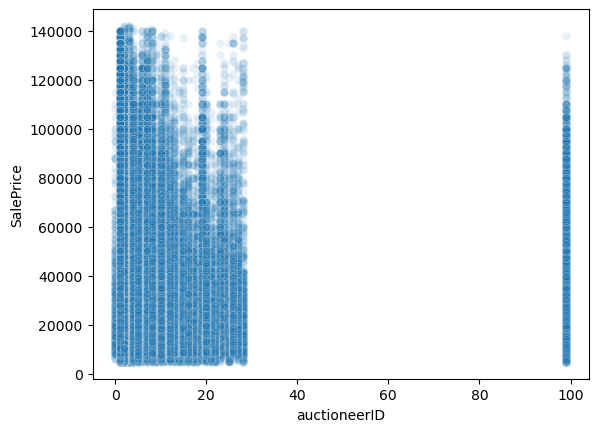

In [20]:
sns.scatterplot(data=df, x='auctioneerID', y='SalePrice', alpha=0.1);

C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


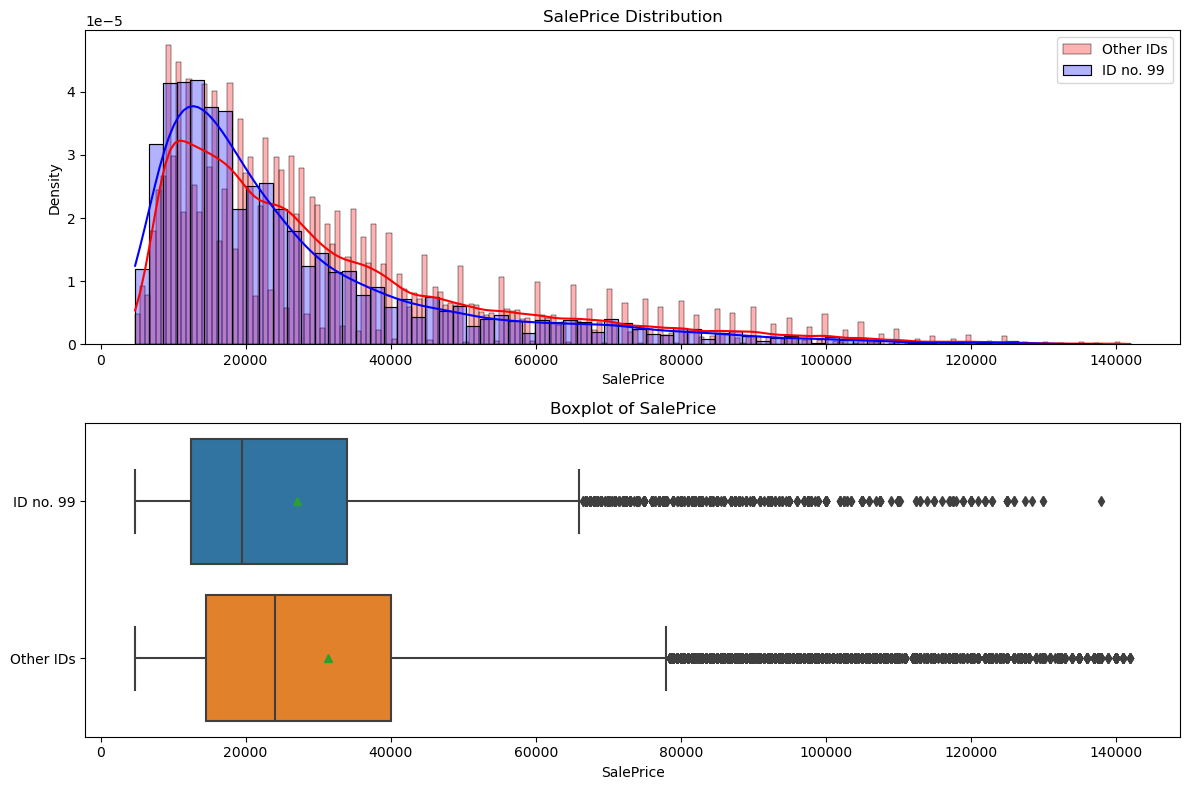

In [21]:
# Step1: Check to see whether auctioneerID no. 99 is a form of missing value

#first we set aside the actual missing values 
df_temp = df.dropna(subset='auctioneerID')

mask = df_temp.auctioneerID == 99

# Extracting data for each group
id99 = df_temp[mask]['SalePrice']
others = df_temp[~mask]['SalePrice']

# Create a new DataFrame for boxplot and histplot
boxplot_data = pd.DataFrame({
    'SalePrice': pd.concat([id99, others]),
    'Group': ['ID no. 99'] * len(id99) + ['Other IDs'] * len(others)
})

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Histpgram
sns.histplot(others, ax=ax[0], alpha=0.3, stat='density', color='r', label='Other IDs', kde= True)
sns.histplot(id99, ax=ax[0], alpha=0.3, stat='density', color='b', label='ID no. 99', kde= True)
ax[0].legend()
ax[0].set_title('SalePrice Distribution')

# Boxplot
sns.boxplot(x='SalePrice', y='Group', data=boxplot_data, ax=ax[1], orient='h', showmeans=True)
ax[1].set_title('Boxplot of SalePrice')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

Although the mean of the two groups seem to be different, the histogram and boxplot of the two groups show a great overlap so it seems that there is no significant differnece between the mean of Sale Price in these two groups. However, to confirm our conclusion, we run the `Wilcoxon` test on these two groups. The reason we choose `Wilcoxon` over the two-sample `t-test` is that two assumptions of the `t-test` is not met here:
1. Normality
2. Homoscedasticity

Our Hypotheses are as follows:

- H0: $μ_{1}$ = $μ_{2}$
- H1: $μ_{1}$ ≠ $μ_{2}$

In [22]:
# Confirming our conclusion using statistical analysis (Wilcoxon test)
u_stat, p_val_mw = mannwhitneyu(others, id99, alternative='two-sided')
if p_val_mw < 0.05:
    print('H0 is rejected. AuctioneerID 99 should be treated as a missing value.')
else:
    print('There is no significant difference and auctioneerID 99 should be treated as a valid id.')

H0 is rejected. AuctioneerID 99 should be treated as a missing value.


Well that's contradictory to what we expected. We calculate the effect size (e.g., Cohen’s d) to understand the magnitude of the difference between the two groups. Even a small p-value might correspond to a negligible effect size, especially in large datasets.
Cohen's d is a measure of effect size used to indicate the standardized difference between two means. The interpretation of Cohen's d is somewhat subjective, but commonly used thresholds are:

- 0.2: Small effect
- 0.5: Medium effect
- 0.8: Large effect

In [23]:
# Calculate Cohen's d
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

effect_size = cohen_d(others, id99)
effect_size

0.18433955356905335

Given the effect size of 0.184:
1. **Small Effect:** This is close to the threshold of 0.2, which means the difference between the group with auctioneerID 99 and other IDs is small.
2. **Practical Implication:** Even though the wilcoxon indicates a statistically significant difference (p-value < 0.05), the small effect size suggests that the practical difference between the two groups is minor.

Thus, we decide to treat auctioneer id 99 as a valid id. However, one can run a sensetivity analysis on either case to see which results in a better prediction performance.

C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


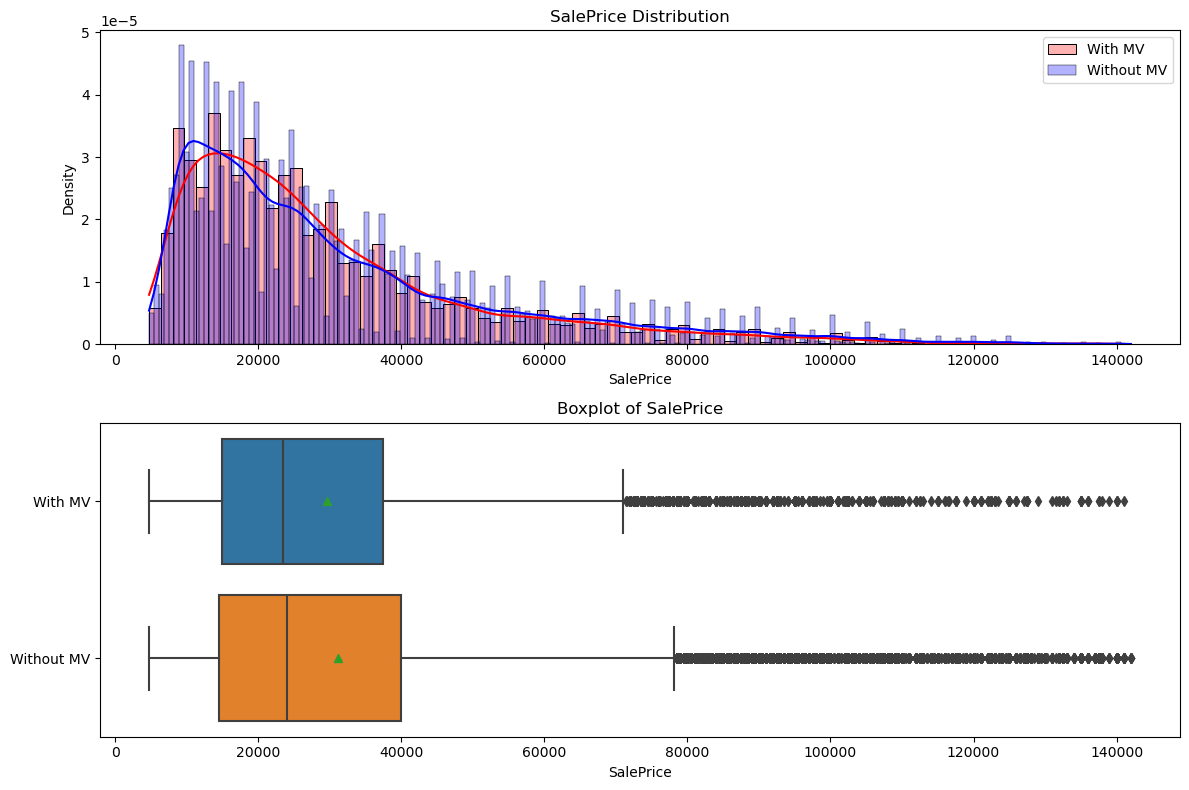

In [24]:
# Step2: Check to see which type of missing value are we dealing with in auctioneerID
mask = df.auctioneerID.isna()

# Extracting data
mask = df.auctioneerID.isna()
MV = df[mask]['SalePrice']
WMV = df[~mask]['SalePrice']

# Create a new DataFrame for boxplot and histplot
boxplot_data = pd.DataFrame({'SalePrice': pd.concat([MV, WMV]),
                            'Labels':['With MV']*len(MV)+['Without MV']*len(WMV)})

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Histogram
sns.histplot(MV, label='With MV', stat='density', color='red', kde=True, alpha= 0.3, ax=ax[0])
sns.histplot(WMV, label='Without MV', stat='density', color='blue', kde=True, alpha= 0.3, ax=ax[0])
ax[0].legend()
ax[0].set_title('SalePrice Distribution')

# Boxplots
sns.boxplot(x= 'SalePrice', y='Labels', data=boxplot_data, ax=ax[1], orient='h', showmeans=True)
ax[1].set_title('Boxplot of SalePrice')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

Same as the previous one, the histogram and the boxplot of the two groups show a great overlap so it seems that there is no significant differnece between the mean of Sale Price in these two groups. However, to confirm our conclusion, we run the `Wilcoxon` test on these two groups. The reason we choose `Wilcoxon` over the two-sample `t-test` is that two assumptions of the `t-test` is not met here:
1. Normality
2. Homoscedasticity

Our Hypotheses are as follows:

- H0: $μ_{1}$ = $μ_{2}$
- H1: $μ_{1}$ ≠ $μ_{2}$

In [25]:
u_stat, p_val_mw = mannwhitneyu(WMV, MV, alternative='two-sided')

if p_val_mw < 0.05:
    print('H0 is rejected. Missing values are of type MNAR and thus should be discarded.')
else:
    print('There is no significant difference and the missing values are of type MCAR and should be imputed.')

H0 is rejected. Missing values are of type MNAR and thus should be discarded.


We are experiencing the same situation as above, so once again we calculate the effect size of this difference:

In [26]:
cohen_d(WMV, MV)

0.06693594945211787

Given the effect size of 0.067:
1. **Small Effect:** The difference between the group with missing values and the rest is small.
2. **Practical Implication:** Even though the wilcoxon indicates a statistically significant difference (p-value < 0.05), the small effect size suggests that the practical difference between the two groups is minor.

Thus, since the nature of the missing values are of type MCAR, we decide to keep them as is; that's because considering the value_counts of IDs and the nominal nature of this feature, apart from IDs ranging from 1-3, we can mark the rest as `Others` without imputing the missing values and introducing bias.

In [27]:
# Replacing values other than 1-3 with Other
df.auctioneerID = df.auctioneerID.apply(lambda x: x if x in range(1, 4) else 'Other')

In [28]:
cols_to_cat.add('auctioneerID')

### Inspecting YearMade

In [29]:
df.YearMade.describe()

count   401,125.00
mean      1,899.16
std         291.80
min       1,000.00
25%       1,985.00
50%       1,995.00
75%       2,000.00
max       2,013.00
Name: YearMade, dtype: float64

In [30]:
# Turning YearMade = 1000 into NAN values
df.loc[:, 'YearMade']= df['YearMade'].apply(lambda x: np.nan if x == 1000 else x)

In [31]:
df[df.YearMade>2011]

SalesID  SalePrice  MachineID  ModelID datasource auctioneerID  \
295706  2226857      35000      40066     4125        136         1.00   
395524  6275685      55000     156521     1453      Other         1.00   

        YearMade  MachineHoursCurrentMeter UsageBand   saledate  ...  \
295706  2,012.00                  4,534.00       Low 2010-05-06  ...   
395524  2,013.00                       NaN       NaN 2011-12-07  ...   

       Undercarriage_Pad_Width Stick_Length Thumb Pattern_Changer  \
295706                     NaN          NaN   NaN             NaN   
395524                     NaN          NaN   NaN             NaN   

       Grouser_Type Backhoe_Mounting Blade_Type Travel_Controls  \
295706          NaN              NaN   Straight             NaN   
395524          NaN              NaN        NaN             NaN   

       Differential_Type Steering_Controls  
295706               NaN               NaN  
395524          Standard      Conventional  

[2 rows x 53 columns]

In [32]:
# training data are supposed to be up to the end of the 2011, so a YearMade beyound that is not possible
df['YearMade'] = df['YearMade'].apply(lambda x: np.nan if x > 2011 else x)

In [33]:
df.YearMade.isna().sum()

38187

C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


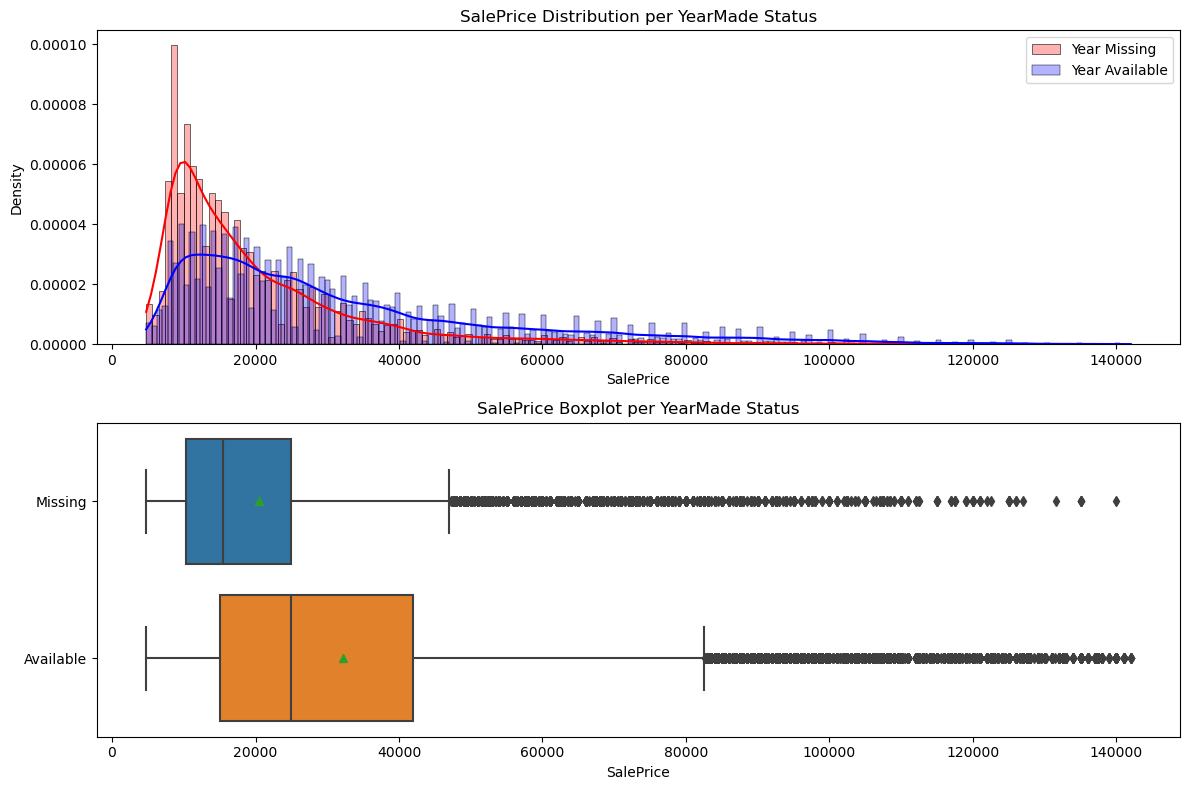

In [34]:
# Checking to see if the missing values in the YearMade are MCAR, MAR, or MNAR

# Extracting data
mask = df.YearMade.isna()
MV = df[mask]['SalePrice']
WMV = df[~mask]['SalePrice']

# Create a new DataFrame for boxplot and histplot
boxplot_data = pd.DataFrame({'SalePrice': pd.concat([MV, WMV]),
                             'Labels': ['Missing']*len(MV)+['Available']*len(WMV)})

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# Histogram
sns.histplot(MV, label='Year Missing', kde=True, stat='density', color='red', ax=ax[0], alpha= 0.3)
sns.histplot(WMV, label='Year Available', kde=True, stat='density', color='blue', ax=ax[0], alpha=0.3)
ax[0].set_title('SalePrice Distribution per YearMade Status')
ax[0].legend()

# Boxplot
sns.boxplot(x='SalePrice', y='Labels', data=boxplot_data, orient='h', showmeans=True)
ax[1].set_title('SalePrice Boxplot per YearMade Status')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show();

While analysing the dataset, we suspected whether Machines with the same `ModelID` number are built around the same Year. If so, we can leverage this finding to impute our missing `YearMade` values with the median of those years. Thus, We need to perform two actions now:
1. Confirm our hypothesis throughout the whole dataset
2. Perform Imputation

In [35]:
# Checking if our hypothesis is correct by calculating the min, max, and range of YearMade for each ModelID
model_year_stats = df.groupby(by='ModelID')['YearMade'].agg(['max', 'min', 'median', 'mean', pd.Series.mode]).reset_index()
model_year_stats['range'] = model_year_stats['max'] - model_year_stats['min']
model_year_stats['mean-median'] = model_year_stats['median'] - model_year_stats['mean']

# Set a threshold for the range (e.g., 5 years)
threshold = 5

model_year_stats[model_year_stats['mean-median'] > threshold].sort_values('mean-median')

ModelID      max      min   median     mean                      mode  \
652      3168 2,003.00 1,981.00 1,999.00 1,993.94                  1,999.00   
3143    15891 2,007.00 1,982.00 2,006.00 2,000.92          [2006.0, 2007.0]   
1475     6623 2,000.00 1,985.00 2,000.00 1,994.71                  2,000.00   
4263    22757 2,006.00 1,969.00 2,006.00 2,000.57                  2,006.00   
1801     8851 2,008.00 1,978.00 2,005.00 1,999.21                  2,006.00   
4426    23812 1,998.00 1,919.00 1,988.00 1,981.27  [1987.0, 1988.0, 1994.0]   
5083    30174 2,008.00 1,920.00 2,006.00 1,999.08                  2,006.00   
109       332 2,007.00 1,919.00 1,999.00 1,991.48                  2,000.00   
4582    25089 2,004.00 1,977.00 2,004.00 1,995.00                  2,004.00   
5011    28657 2,007.00 1,919.00 1,999.00 1,968.03          [1920.0, 2000.0]   

      range  mean-median  
652   22.00         5.06  
3143  25.00         5.08  
1475  15.00         5.29  
4263  37.00         5.43  
1801  30.00         5.79  
4426  79.00         6.73  
5083  88.00         6.92  
109   88.00         7.52  
4582  27.00         9.00  
5011  88.00        30.97

To impute the missing values in the `YearMade` column based on the median `YearMade` for each `ModelID`, we take the following steps:
1. Group by ModelID to calculate the median YearMade for each group.
2. Create a mapping from ModelID to its corresponding median YearMade.
3. Apply this mapping to fill in the missing values in the YearMade column.
4. Compare the Histogram of `YearMade` before and after the imputation to make sure the distribution of data has not changed significantly.

C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


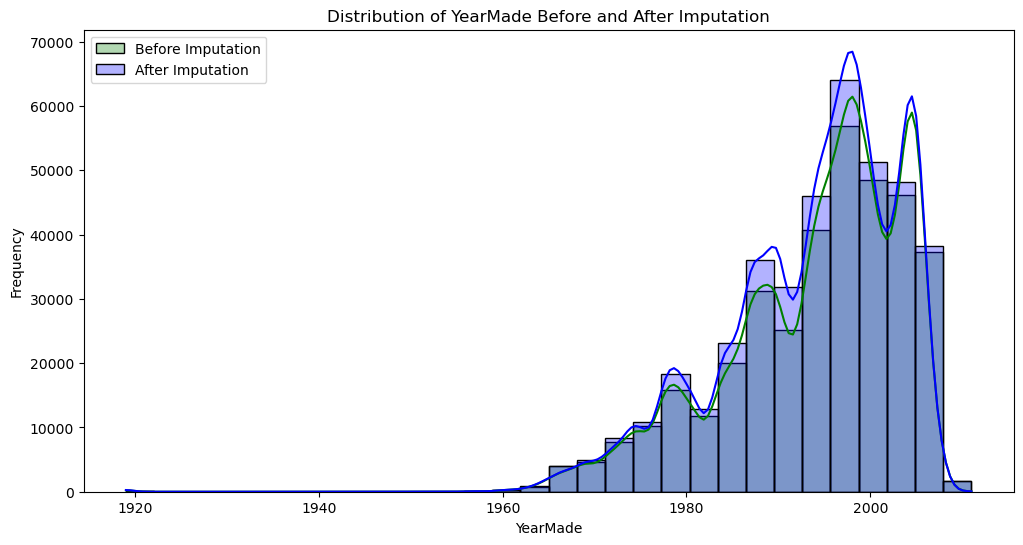

In [36]:
# Step 1: Group by ModelID and calculate the median YearMade for each group
model_year_medians = df.groupby(['ModelID'])['YearMade'].median()

# Step 2: Create a mapping from ModelID to its corresponding median YearMade
model_year_mapping = model_year_medians.to_dict()

# Step 3: Apply the mapping to fill in the missing values in the YearMade column
temp_year = df.apply(lambda row: model_year_mapping[row['ModelID']] if pd.isna(row['YearMade']) else row['YearMade'], axis=1)
temp_year = temp_year.fillna(np.median(temp_year.dropna()))

# Step 4: Plot both distributions together for comparison
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(x='YearMade', data=df, kde=True, bins= 30, color='green', alpha=0.3, label='Before Imputation')
sns.histplot(temp_year, kde=True,  bins= 30, color='blue', alpha=0.3, label='After Imputation')
plt.xlabel('YearMade')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of YearMade Before and After Imputation')
plt.show()

In [37]:
# Replacing the imputed values
df['YearMade'] = temp_year

### Inspecting MachineHoursCurrentMeter

In [38]:
# First turning all 0s to null according to the data dictionary of the dataset
df['MachineHoursCurrentMeter'] = df['MachineHoursCurrentMeter'].replace(0, np.nan)

In [39]:
df['MachineHoursCurrentMeter'].describe()

count      69,639.00
mean        7,089.06
std        39,176.92
min             2.00
25%         1,572.00
50%         3,138.00
75%         6,267.50
max     2,483,300.00
Name: MachineHoursCurrentMeter, dtype: float64

In [40]:
# Checking the Outliers
df_temp = df[["MachineHoursCurrentMeter", "YearMade"]].copy()

df_temp["ReportDate"] = 2012
df_temp["24h"] = 365 * 24 * (df_temp["ReportDate"] - df_temp["YearMade"])
df_temp["Suspicious_MHCM"] = df_temp["MachineHoursCurrentMeter"]>df_temp["24h"]

# Identifying records that state the machine has worked more than 24h per day during their lifespan
MHCM_outliers = df_temp[df_temp["Suspicious_MHCM"] == True].sort_values(['YearMade']).index.tolist()

# Replacing with NAN values
df.loc[MHCM_outliers, 'MachineHoursCurrentMeter'] = np.nan

In [41]:
df.MachineHoursCurrentMeter.describe()

count    69,184.00
mean      4,741.45
std       5,380.63
min           2.00
25%       1,562.00
50%       3,107.00
75%       6,173.25
max     161,800.00
Name: MachineHoursCurrentMeter, dtype: float64

To impute the missing values in the `MachineHoursCurrentMeter` column based on the median value of `MachineHoursCurrentMeter` grouped by `ModelID` and `YearMade`, we take the following steps:

1. Group the data by ModelID and YearMade to calculate the median MachineHoursCurrentMeter for each group.
2. Create a mapping from the combination of ModelID and YearMade to their corresponding median MachineHoursCurrentMeter.
3. Apply this mapping to fill in the missing values in the MachineHoursCurrentMeter column.
4. Compare the Histogram of MachineHoursCurrentMeter before and after the imputation to make sure the distribution of data has not changed significantly.

C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Pouya\miniconda3\envs\practice_environment\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


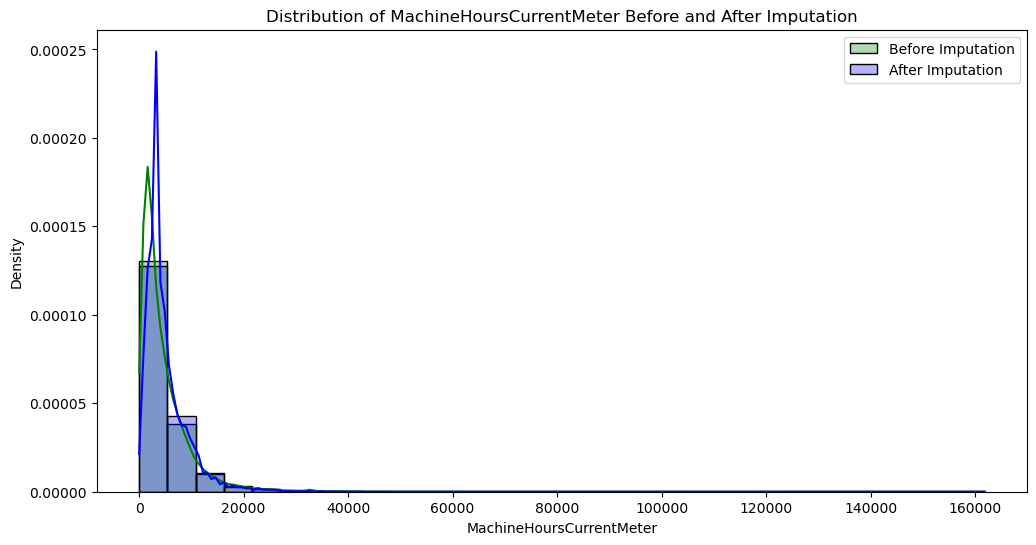

In [42]:
# Step 1: Group by ModelID and YearMade and calculate the median MachineHoursCurrentMeter for each group
overall_median_hours = df['MachineHoursCurrentMeter'].median()
grouped = df.groupby(['ModelID', 'YearMade'])['MachineHoursCurrentMeter'].median().reset_index()
grouped = grouped.dropna(subset=['MachineHoursCurrentMeter'])

# Step 2: Create a dictionary mapping from (ModelID, YearMade) to median MachineHoursCurrentMeter
median_mapping = grouped.set_index(['ModelID', 'YearMade'])['MachineHoursCurrentMeter'].to_dict()

# Step 3: Define a function to fill missing values using the mapping
def impute_machine_hours(row):
    if pd.isna(row['MachineHoursCurrentMeter']):
        return median_mapping.get((row['ModelID'], row['YearMade']), overall_median_hours)
    else:
        return row['MachineHoursCurrentMeter']
# Apply the function to the DataFrame
machine_hour_temp = df.apply(impute_machine_hours, axis=1)

# Step 4: Plot both distributions together for comparison
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(x='MachineHoursCurrentMeter', data=df, stat='density', kde=True, bins= 30, color='green', alpha=0.3, label='Before Imputation')
sns.histplot(machine_hour_temp, stat='density', kde=True,  bins= 30, color='blue', alpha=0.3, label='After Imputation')
plt.xlabel('MachineHoursCurrentMeter')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of MachineHoursCurrentMeter Before and After Imputation')
plt.show()

In [43]:
df.MachineHoursCurrentMeter = machine_hour_temp

### Inspecting saledate

In [44]:
# Generating Year & Month from saledate
df['SaleYear'] = df.saledate.dt.year
df['SaleMonth'] = df.saledate.dt.month

In [45]:
df.head()

SalesID  SalePrice  MachineID  ModelID datasource auctioneerID  YearMade  \
0  1139246      66000     999089     3157      Other         3.00  2,004.00   
1  1139248      57000     117657       77      Other         3.00  1,996.00   
2  1139249      10000     434808     7009      Other         3.00  2,001.00   
3  1139251      38500    1026470      332      Other         3.00  2,001.00   
4  1139253      11000    1057373    17311      Other         3.00  2,007.00   

   MachineHoursCurrentMeter UsageBand   saledate  ... Thumb Pattern_Changer  \
0                     68.00       Low 2006-11-16  ...   NaN             NaN   
1                  4,640.00       Low 2004-03-26  ...   NaN             NaN   
2                  2,838.00      High 2004-02-26  ...   NaN             NaN   
3                  3,486.00      High 2011-05-19  ...   NaN             NaN   
4                    722.00    Medium 2009-07-23  ...   NaN             NaN   

  Grouser_Type Backhoe_Mounting Blade_Type Travel_Controls Differential_Type  \
0          NaN              NaN        NaN             NaN          Standard   
1          NaN              NaN        NaN             NaN          Standard   
2          NaN              NaN        NaN             NaN               NaN   
3          NaN              NaN        NaN             NaN               NaN   
4          NaN              NaN        NaN             NaN               NaN   

  Steering_Controls SaleYear SaleMonth  
0      Conventional     2006        11  
1      Conventional     2004         3  
2               NaN     2004         2  
3               NaN     2011         5  
4               NaN     2009         7  

[5 rows x 55 columns]

In [46]:
cols_to_del.add('saledate')

## Categorical Columns

In [47]:
cat_cols = df.select_dtypes('object').copy()
cat_cols.describe().T

count unique  \
datasource                  401125      3   
auctioneerID            401,125.00   4.00   
UsageBand                    69639      3   
fiModelDesc                 401125   4999   
fiBaseModel                 401125   1950   
fiSecondaryDesc             263934    175   
fiModelSeries                56908    122   
fiModelDescriptor            71919    139   
ProductSize                 190350      6   
fiProductClassDesc          401125     74   
state                       401125     53   
ProductGroup                401125      6   
ProductGroupDesc            401125      6   
Drive_System                104361      4   
Enclosure                   400798      5   
Forks                        13777      1   
Pad_Type                      8520      3   
Ride_Control                 85490      2   
Stick                        79134      2   
Transmission                160083      7   
Turbocharged                  3923      1   
Blade_Extension                527      1   
Blade_Width                  15936      5   
Enclosure_Type                3296      2   
Engine_Horsepower            25219      2   
Hydraulics                  320560     11   
Pushblock                     5756      1   
Ripper                       20685      3   
Scarifier                    12511      1   
Tip_Control                   9012      2   
Tire_Size                    48379     16   
Coupler                      29370      2   
Coupler_System                3028      1   
Grouser_Tracks                2847      1   
Hydraulics_Flow              43337      2   
Track_Type                   99153      2   
Undercarriage_Pad_Width      20221     18   
Stick_Length                 20398     28   
Thumb                        16195      2   
Pattern_Changer               8963      2   
Grouser_Type                 99153      3   
Backhoe_Mounting                20      1   
Blade_Type                   68402      9   
Travel_Controls               9911      6   
Differential_Type            69411      4   
Steering_Controls            69369      5   

                                                                       top  \
datasource                                                             132   
auctioneerID                                                          1.00   
UsageBand                                                           Medium   
fiModelDesc                                                           310G   
fiBaseModel                                                            580   
fiSecondaryDesc                                                          C   
fiModelSeries                                                           II   
fiModelDescriptor                                                        L   
ProductSize                                                         Medium   
fiProductClassDesc       Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...   
state                                                              Florida   
ProductGroup                                                           TEX   
ProductGroupDesc                                          Track Excavators   
Drive_System                                               Two Wheel Drive   
Enclosure                                                            OROPS   
Forks                                                                  Yes   
Pad_Type                                                        Reversible   
Ride_Control                                                            No   
Stick                                                             Standard   
Transmission                                                      Standard   
Turbocharged                                                           Yes   
Blade_Extension                                                        Yes   
Blade_Width                                                            14'   
Enclosure_Type                           

In [49]:
cat_cols.isna().sum().sort_values()

datasource                      0
ProductGroupDesc                0
ProductGroup                    0
fiProductClassDesc              0
state                           0
fiModelDesc                     0
auctioneerID                    0
fiBaseModel                     0
Enclosure                     327
Hydraulics                  80565
fiSecondaryDesc            137191
ProductSize                210775
Transmission               241042
Drive_System               296764
Grouser_Type               301972
Track_Type                 301972
Ride_Control               315635
Stick                      321991
fiModelDescriptor          329206
UsageBand                  331486
Differential_Type          331714
Steering_Controls          331756
Blade_Type                 332723
fiModelSeries              344217
Tire_Size                  352746
Hydraulics_Flow            357788
Coupler                    371755
Engine_Horsepower          375906
Ripper                     380440
Stick_Length  

### Inspecting 'fiModelDesc', 'fiBaseModel' , 'fiSecondaryDesc' , 'fiModelSeries' , 'fiModelDescriptor'

In [50]:
cat_cols[['fiModelDesc', 'fiBaseModel' , 'fiSecondaryDesc' , 'fiModelSeries' , 'fiModelDescriptor']].iloc[3:7,:]

fiModelDesc fiBaseModel fiSecondaryDesc fiModelSeries fiModelDescriptor
3    PC120-6E       PC120             NaN           -6E               NaN
4        S175        S175             NaN           NaN               NaN
5        310G         310               G           NaN               NaN
6      790ELC         790               E           NaN                LC

In [51]:
# Check the variety of the rest of the columns according to the ModelID
df.groupby(['ModelID'])[['fiBaseModel' , 'fiSecondaryDesc' , 'fiModelSeries' , 'fiModelDescriptor']].nunique()

fiBaseModel  fiSecondaryDesc  fiModelSeries  fiModelDescriptor
ModelID                                                                
28                 1                1              1                  0
29                 1                1              1                  0
31                 1                1              1                  0
34                 1                1              1                  0
43                 1                0              1                  0
...              ...              ...            ...                ...
36928              1                1              0                  0
36933              1                1              0                  0
37196              1                0              0                  0
37197              1                0              0                  0
37198              1                1              0                  0

[5218 rows x 4 columns]

In [52]:
cols_to_del.update(['fiModelDesc', 'fiBaseModel' , 'fiSecondaryDesc' , 'fiModelSeries' , 'fiModelDescriptor'])

### Inspecting UsageBand

In [53]:
df_temp = df[['ModelID', 'YearMade', 'MachineHoursCurrentMeter' , 'UsageBand']].sort_values(['ModelID'])
df_temp.head()

ModelID  YearMade  MachineHoursCurrentMeter UsageBand
395930       28  2,008.00                  1,185.00       NaN
368461       28  2,008.00                  1,505.00      High
368462       28  2,008.00                  1,142.00      High
368463       28  2,008.00                    829.00    Medium
368464       28  2,008.00                  1,331.00    Medium

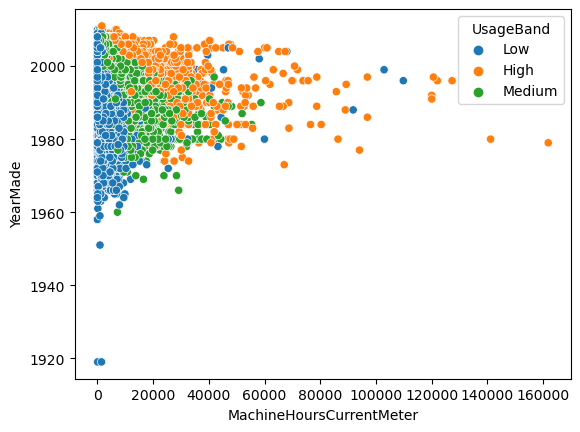

In [54]:
sns.scatterplot(x=df.MachineHoursCurrentMeter, y=df.YearMade, hue=df.UsageBand);

Considering the logic behind how the UsageBand is determined, regardless of high number of missing values we decide to impute them through classification

In [55]:
# Separating data into train & test
mask = df_temp.UsageBand.isna()
train_set = df_temp[~mask]
test_set = df_temp[mask]

X_train = train_set.drop('UsageBand', axis=1)
y_train = train_set['UsageBand']
X_test = test_set.drop('UsageBand', axis=1)
y_test = test_set['UsageBand']

# Standardized data
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train & evaluate the model on training data
knn = KNeighborsClassifier(n_neighbors=3)
cross_val_score(knn, X_train_scaled, y_train, cv=3)

array([0.40356697, 0.51721018, 0.30426916])

In [56]:
# Predicting UsageBand
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
y_pred

array(['High', 'High', 'High', ..., 'Low', 'Low', 'Medium'], dtype=object)

In [57]:
# Replacing missing values with predicted values
df.loc[df.UsageBand.isna(), 'UsageBand'] = y_pred

In [58]:
ordinal_mapping = {'Low': 3, 'Medium': 2, 'High': 1}

# Encode the labels using the mapping
df['UsageBand'] = df['UsageBand'].map(ordinal_mapping)

### Inspecting ProductGroup, ProductGroupDesc, fiProductClassDesc, & ProductSize

In [59]:
df.ProductGroupDesc.unique()

array(['Wheel Loader', 'Skid Steer Loaders', 'Track Excavators',
       'Backhoe Loaders', 'Track Type Tractors', 'Motor Graders'],
      dtype=object)

In [60]:
df.ProductGroup.unique()

array(['WL', 'SSL', 'TEX', 'BL', 'TTT', 'MG'], dtype=object)

#### Product Group
There are 6 types of Bulldozers in this dataset:
1. **Wheel Loader:** This machine has large wheels and is used for scooping and transporting materials. It features a front-mounted bucket.
2. **Skid Steer Loaders:** These are small, versatile loaders with lift arms that can attach to various tools. They are known for their maneuverability and compact size.
3. **Track Excavators:** Also known simply as excavators, these machines have tracks for movement and a large arm with a bucket for digging and moving earth.
4. **Backhoe Loaders:** These machines combine a loader on the front and a backhoe on the back, making them ersatile for various digging and loading tasks.
5. **Track Type Tractors:** Commonly referred to as bulldozers, these are powerful machines with large tracks and a wide blade for pushing earth.
6. **Motor Graders:** These machines have a long blade used for grading surfaces, often used in road construction and maintenance.

There are no missing values in either `ProductGroupDesc` or `ProductGroup` and since ProductGroup is the abbreviate version of ProductGroupDesc, we keep `ProductGroupDesc` and discard ProductGroup.

In [61]:
cols_to_del.add('ProductGroup')

#### fiProductClassDesc

In [62]:
df.fiProductClassDesc.head()

0             Wheel Loader - 110.0 to 120.0 Horsepower
1             Wheel Loader - 150.0 to 175.0 Horsepower
2    Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...
3    Hydraulic Excavator, Track - 12.0 to 14.0 Metr...
4    Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...
Name: fiProductClassDesc, dtype: object

General Size Categories Based on Horsepower and Operating Capacity

**Horsepower (HP) Ranges:**
- **Compact:** 0 to 40 HP
- **Mini:** 40 to 60 HP
- **Small:** 60 to 100 HP
- **Medium:** 100 to 200 HP
- **Large:** 200 to 500 HP
- **Very Large:** 500+ HP

**Operating Capacity (Weight) Ranges:**
- **Compact:** 0 to 701 lbs
- **Mini:** 701 to 1251 lbs
- **Small:** 1251 to 1751 lbs
- **Medium:** 1751 to 2701 lbs
- **Large:** 2701+ lbs

**Metric Tons:**
- **Compact:** 0 to 2 metric tons
- **Mini:** 2 to 4 metric tons
- **Small:** 4 to 8 metric tons
- **Medium:** 8 to 20 metric tons
- **Large:** 20 to 50 metric tons
- **Very Large:** 50+ metric tons

**Steps:**
1. Extracting the configuration data

In [63]:
# Function to extract numbers and specific text patterns from text
def extract_numbers(text):
    # Use regular expression to find all numeric values
    numbers = re.findall(r'\d+\.?\d*', text)
    # Convert the extracted strings to int
    numbers = [float(num) for num in numbers]
        
    # Define specific text patterns to search for
    specific_texts = ['Horsepower', 'Metric Tons', 'Operating Capacity', 'Digging Depth', 'Compact']
    # Use regular expression to find specific text patterns
    found_texts = [pattern for pattern in specific_texts if re.search(pattern, text, re.IGNORECASE)]

    if len(numbers + found_texts) == 0:
        return np.nan
    else:
        return numbers + found_texts

df['config'] = df['fiProductClassDesc'].apply(extract_numbers)

In [211]:
cols_to_del.update({'fiProductClassDesc', 'config'})

#### ProductSize

- **Wheel Loaders**:
  - **Compact**: highly maneuverable loaders used in tight spaces and smaller projects.
    - **Horsepower**: Up to 40 HP
    - **Operating Capacity**: Up to 2000 lbs
    - **Metric Tons**: Up to 1 ton
  - **Small**: used for light to medium-duty tasks.
    - **Horsepower**: 40-100 HP
    - **Operating Capacity**: 2000-5000 lbs
    - **Metric Tons**: 1-2 tons
  - **Medium**: versatile machines used in a variety of applications.
    - **Horsepower**: 100-200 HP
    - **Operating Capacity**: 5000-10000 lbs
    - **Metric Tons**: 2-5 tons
  - **Large**: used for heavy-duty tasks in construction and mining.
    - **Horsepower**: 200-350 HP
    - **Operating Capacity**: 10000-20000 lbs
    - **Metric Tons**: 5-10 tons
  - **Very Large**: used in large-scale mining and heavy construction.
    - **Horsepower**: Over 350 HP
    - **Operating Capacity**: 20000+ lbs
    - **Metric Tons**: 10+ tons

- **Skid Steer Loaders**:
  - **Compact**: designed for light-duty tasks and maneuverability in confined spaces
    - **Horsepower**: Up to 40 HP
    - **Operating Capacity**: Up to 1500 lbs
    - **Metric Tons**: Up to 0.75 tons
  - **Small**: more powerful, still highly maneuverable
    - **Horsepower**: 40-100 HP
    - **Operating Capacity**: 1500-3000 lbs
    - **Metric Tons**: 0.75-1.5 tons
  - **Medium**: larger models for more demanding tasks, though skid steers are generally on the smaller end of the size spectrum compared to other equipment.
    - **Horsepower**: 100-200 HP
    - **Operating Capacity**: 3000-5000 lbs
    - **Metric Tons**: 1.5-2.5 tons

- **Track Excavators**:
  - **Mini**: also referred to as mini or compact excavators, used for small-scale tasks and in tight spaces.
    - **Horsepower**: Up to 40 HP
    - **Operating Capacity**: Up to 2000 lbs
    - **Metric Tons**: Up to 1 ton
  - **Small**: for small to medium tasks.
    - **Horsepower**: 40-100 HP
    - **Operating Capacity**: 2000-5000 lbs
    - **Metric Tons**: 1-2 tons
  - **Medium**: general-purpose excavators for a variety of tasks.
    - **Horsepower**: 100-200 HP
    - **Operating Capacity**: 5000-10000 lbs
    - **Metric Tons**: 2-5 tons
  - **Large**: for heavy construction and mining tasks.
    - **Horsepower**: 200-350 HP
    - **Operating Capacity**: 10000-20000 lbs
    - **Metric Tons**: 5-10 tons
  - **Very Large**: for large-scale mining and earthmoving.
    - **Horsepower**: Over 350 HP
    - **Operating Capacity**: 20000+ lbs
    - **Metric Tons**: 10+ tons

- **Backhoe Loaders**:
  - **Compact**: smaller, versatile machines.
    - **Horsepower**: Up to 40 HP
    - **Operating Capacity**: Up to 2000 lbs
    - **Metric Tons**: Up to 1 ton
  - **Small**: used for a variety of tasks on smaller construction sites.
    - **Horsepower**: 40-100 HP
    - **Operating Capacity**: 2000-5000 lbs
    - **Metric Tons**: 1-2 tons
  - **Medium**: larger models for more demanding tasks.
    - **Horsepower**: 100-200 HP
    - **Operating Capacity**: 5000-10000 lbs
    - **Metric Tons**: 2-5 tons

- **Track Type Tractors**:
  - **Small**: used for residential and light construction projects.
    - **Horsepower**: 100-200 HP
    - **Operating Capacity**: 10000-20000 lbs
    - **Metric Tons**: 5-10 tons
  - **Medium**: versatile machines for medium to heavy construction.
    - **Horsepower**: 200-350 HP
    - **Operating Capacity**: 20000-40000 lbs
    - **Metric Tons**: 10-20 tons
  - **Large**: used in large construction projects and mining.
    - **Horsepower**: 350-500 HP
    - **Operating Capacity**: 40000-60000 lbs
    - **Metric Tons**: 20-30 tons
  - **Very Large**: for the largest construction and mining tasks.
    - **Horsepower**: Over 500 HP
    - **Operating Capacity**: 60000+ lbs
    - **Metric Tons**: 30+ tons

- **Motor Graders**:
  - **Medium**: commonly used in road construction and maintenance.
    - **Horsepower**: 100-200 HP
    - **Operating Capacity**: 10000-20000 lbs
    - **Metric Tons**: 5-10 tons
  - **Large**: used for larger road construction projects and other heavy-duty grading tasks.*
    - **Horsepower**: 200-350 HP
    - **Operating Capacity**: 20000-40000 lbs
    - **Metric Tons**: 10-20 tons
  - **Very Large**: used in large-scale construction and mining operations.
    - **Horsepower**: Over 350 HP
    - **Operating Capacity**: 40000+ lbs
    - **Metric Tons**: 20+ tons


**Steps we are going to take here:**
1. Decide whether we can merge `Small`, `Compact`, and `Mini` as one
2. Turning the `Large/Medium` category to either `Large` or `Medium` according to `HorsePower` or `Operating Capacity` and remove `Large/Medium` category
3. Impute the Missing Sizes according to extracted feature `config`
4. Decide how to deal with the rest of the missing values

In [65]:
df.ProductSize.value_counts(dropna=False)

ProductSize
NaN               210775
Medium             62274
Large / Medium     49678
Small              26494
Mini               24840
Large              20975
Compact             6089
Name: count, dtype: int64

In [66]:
# Understanding the distribution of Product Size over Product Group
pd.crosstab(df.ProductSize, df.ProductGroupDesc, dropna=False, margins=False)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
ProductSize                                                            
Compact                         0              0                   0   
Large                           0              0                   0   
Large / Medium                  0              0                   0   
Medium                          0              0                   0   
Mini                            0              0                   0   
Small                           0              0                   0   
NaN                         79415          25489               43488   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  
ProductSize                                                            
Compact                          0                    0          6089  
Large                            0                17537          3438  
Large / Medium               49678                    0             0  
Medium                           0                23578         38696  
Mini                         24840                    0             0  
Small                        26494                    0             0  
NaN                            155                39405         22823

In [67]:
# Checking on the distribution of `Small`, `Mini`, & `Compact` sizes over Product Group
mask = df.ProductSize.isin(['Small', 'Mini', 'Compact'])
pd.crosstab(df[mask].ProductSize, df[mask].ProductGroupDesc)

ProductGroupDesc  Track Excavators  Wheel Loader
ProductSize                                     
Compact                          0          6089
Mini                         24840             0
Small                        26494             0

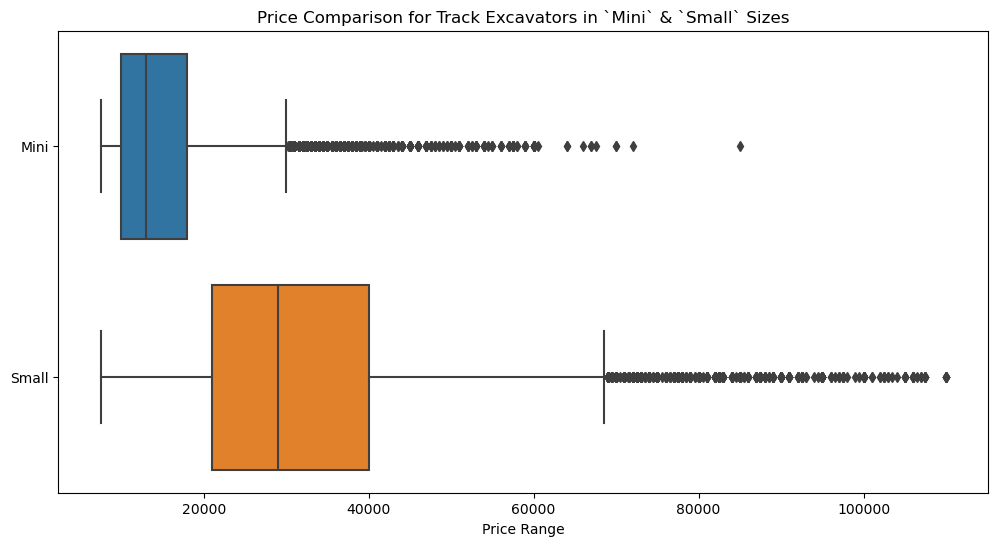

In [68]:
# Check to see if we can merge `Small`, `Mini`, & `Compact` sizes
mini = df[(df.ProductSize == 'Mini')&(df.ProductGroupDesc == 'Track Excavators')]['SalePrice']
small = df[(df.ProductSize == 'Small')&(df.ProductGroupDesc == 'Track Excavators')]['SalePrice']
compact = df[(df.ProductSize == 'Compact')&(df.ProductGroupDesc == 'Track Excavators')]['SalePrice']

box_data = pd.DataFrame({'Price Range': pd.concat([mini, small, compact]),
                         'Size': ['Mini']*len(mini) + ['Small']*len(small) + ['Compact']*len(compact)})

plt.figure(figsize=(12, 6))
sns.boxplot(x='Price Range', y='Size', data=box_data)
plt.ylabel('')
plt.title('Price Comparison for Track Excavators in `Mini` & `Small` Sizes');

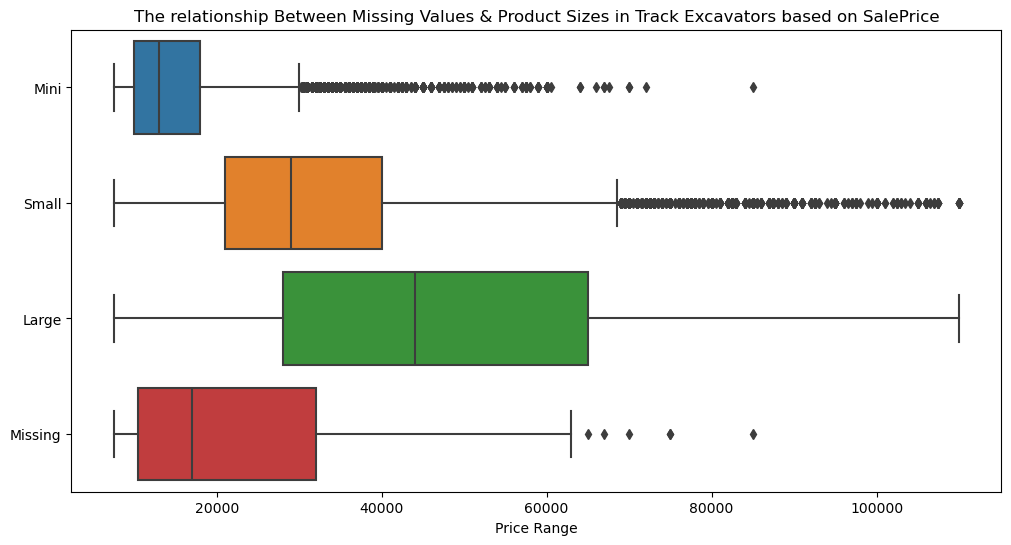

In [69]:
# Checking on Missing Values in `Track Excavators` Group
mini = df[(df.ProductSize == 'Mini')&(df.ProductGroupDesc == 'Track Excavators')]['SalePrice']
small = df[(df.ProductSize == 'Small')&(df.ProductGroupDesc == 'Track Excavators')]['SalePrice']
large = df[(df.ProductSize == 'Large / Medium')&(df.ProductGroupDesc == 'Track Excavators')]['SalePrice']
missing = df[(df.ProductSize.isna())&(df.ProductGroupDesc == 'Track Excavators')]['SalePrice']

box_data = pd.DataFrame({'Price Range': pd.concat([mini, small, large, missing]),
                         'Size': ['Mini']*len(mini) + ['Small']*len(small) + ['Large']*len(large) + ['Missing']*len(missing)})

plt.figure(figsize=(12, 6))
sns.boxplot(x='Price Range', y='Size', data=box_data)
plt.ylabel('')
plt.title('The relationship Between Missing Values & Product Sizes in Track Excavators based on SalePrice');

**Checking the distribution of Missing Values in Wheel Loaders & Track Excavators**

In [70]:
temp = df.copy()
temp['ProductSize'] = temp['ProductSize'].fillna('Missing')

In [71]:
temp['ProductSize'] = temp['ProductSize'].replace('Large / Medium', 'Large')

In [72]:
temp[temp.ProductGroupDesc == 'Track Excavators']['ProductSize'].value_counts(dropna=False)

ProductSize
Large      49678
Small      26494
Mini       24840
Missing      155
Name: count, dtype: int64

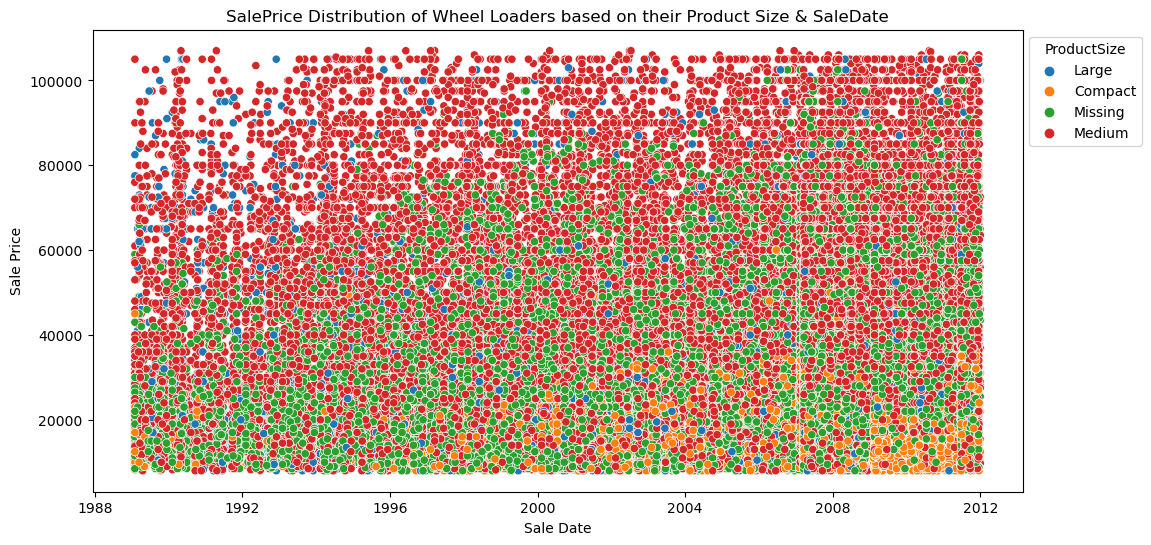

In [73]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.scatterplot(x=temp[temp.ProductGroupDesc == 'Wheel Loader'].saledate,
                y=temp[temp.ProductGroupDesc == 'Wheel Loader'].SalePrice,
                hue=temp[temp.ProductGroupDesc == 'Wheel Loader'].ProductSize,
                hue_order = ['Large', 'Compact', 'Missing', 'Medium'])
plt.title('SalePrice Distribution of Wheel Loaders based on their Product Size & SaleDate')
plt.xlabel('Sale Date')
plt.ylabel('Sale Price')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

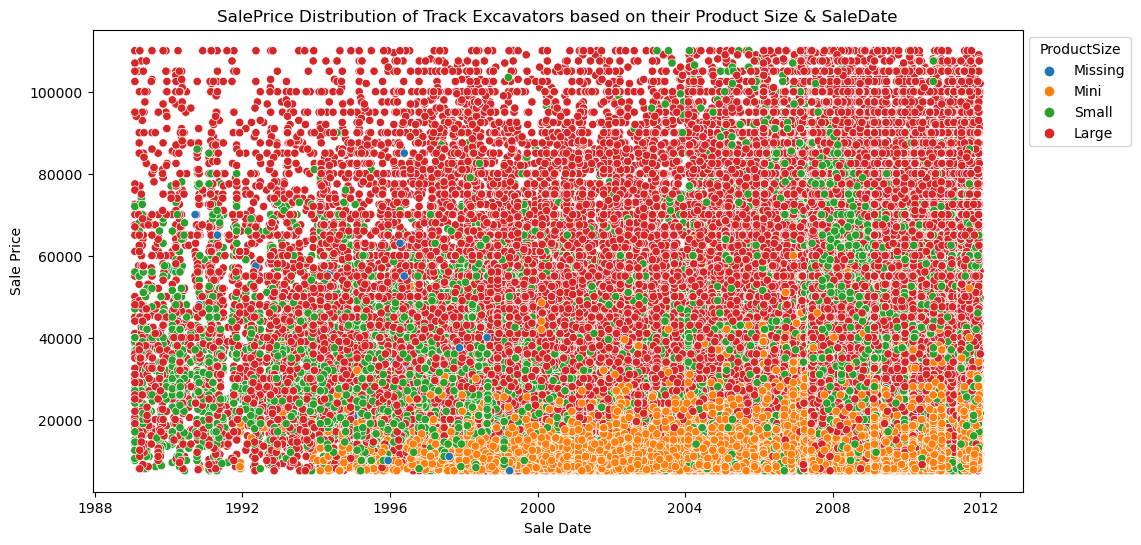

In [74]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(x=temp[temp.ProductGroupDesc == 'Track Excavators'].saledate,
                y=temp[temp.ProductGroupDesc == 'Track Excavators'].SalePrice,
                hue=temp[temp.ProductGroupDesc == 'Track Excavators'].ProductSize,
                hue_order = ['Missing', 'Mini', 'Small', 'Large'])
plt.title('SalePrice Distribution of Track Excavators based on their Product Size & SaleDate')
plt.xlabel('Sale Date')
plt.ylabel('Sale Price')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

According to the two plots above, we see that the missing values in these two groups (`Wheel Loader` and `Track Excavators`) are distributed all over the figure which means they are from various sizes. We could possibly figure out some of these missing values according to the `config` feature we earlier extracted from `fiProductClassDesc`.

In [75]:
horsepower = {
    'Wheel Loader': {
        40: 'Compact',
        100: 'Small',
        200: 'Medium',
        350: 'Large'
    },
    'Skid Steer Loaders': {
        40: 'Compact',
        100: 'Small',
        200: 'Medium'
    },
    'Track Excavators': {
        40: 'Mini',
        100: 'Small',
        200: 'Medium',
        350: 'Large'
    },
    'Backhoe Loaders': {
        40: 'Compact',
        100: 'Small',
        200: 'Medium'
    },
    'Track Type Tractors': {
        100: 'Small',
        200: 'Medium',
        350: 'Large'
    },
    'Motor Graders': {
        100: 'Medium',
        200: 'Large'
    }
}

operatingcap = {
    'Wheel Loader': {
        2000: 'Compact',
        6000: 'Small',
        15000: 'Medium',
        16000: 'Large'
    },
    'Skid Steer Loaders': {
        1500: 'Compact',
        3000: 'Small',
        5000: 'Medium'
    },
    'Track Excavators': {
        2000: 'Mini',
        5000: 'Small',
        10000: 'Medium',
        20000: 'Large'
    },
    'Backhoe Loaders': {
        2000: 'Compact',
        5000: 'Small',
        10000: 'Medium'
    },
    'Track Type Tractors': {
        10000: 'Small',
        20000: 'Medium',
        40000: 'Large'
    },
    'Motor Graders': {
        10000: 'Medium',
        20000: 'Large'
    }
}

mt = {
    'Wheel Loader': {
        3: 'Compact',
        6: 'Small',
        12: 'Medium',
        13: 'Large'
    },
    'Skid Steer Loaders': {
        0.75: 'Compact',
        1.5: 'Small',
        2.5: 'Medium'
    },
    'Track Excavators': {
        6: 'Mini',
        15: 'Small',
        20: 'Medium',
        45: 'Large'
    },
    'Backhoe Loaders': {
        6: 'Compact',
        10: 'Small',
        14: 'Medium',
        15: 'Large'
    },
    'Track Type Tractors': {
        20: 'Small',
        45: 'Medium',
        46: 'Large'
    },
    'Motor Graders': {
        12: 'Small',
        20: 'Medium',
        21: 'Large'
    }
}

dd = {'Backhoe Loaders':{
        10: 'Compact',
        14: 'Small',
        18: 'Medium',
        24: 'Large'
    }
}

In [76]:
# Function to determine product size
def size_imputer(row):
    config = row.config
    product = row.ProductGroupDesc

    # If config is not available return nan
    if not isinstance(config, list):
        return np.nan

    else:
        if config[-1] == 'Horsepower':
            size_dict = horsepower[product]
            max_size = max(value for value in config if isinstance(value, (float, int)))
            max_value = min(value if value >= max_size else max(size_dict.keys()) for value in size_dict)
            return size_dict[max_value]
        if config[-1] == 'Metric Tons':
            size_dict = mt[product]
            max_size = max(value for value in config if isinstance(value, (float, int)))
            max_value = min(value if value >= max_size else max(size_dict.keys()) for value in size_dict)
            return size_dict[max_value]
        if config[-1] == 'Operating Capacity':
            size_dict = operatingcap[product]
            max_size = max(value for value in config if isinstance(value, (float, int)))
            max_value = min(value if value >= max_size else max(size_dict.keys()) for value in size_dict)          
            return size_dict[max_value]
        if config[-1] == 'Digging Depth':
            size_dict = dd[product]
            max_size = max(value for value in config if isinstance(value, (float, int)))
            max_value = min(value if value >= max_size else max(size_dict.keys()) for value in size_dict)          
            return size_dict[max_value]
        if config[-1] == 'Compact':
            return 'Compact'

In [77]:
imputed_size = df.apply(size_imputer, axis=1)

In [78]:
imputed_size.value_counts(dropna=False)

Medium     166662
Large      107339
Small       94649
Mini        17523
Compact     10076
NaN          4876
Name: count, dtype: int64

In [79]:
# Comparing the imputation with actual available values
imputed_size.compare(df.ProductSize,align_axis=1, keep_shape=False, result_names=('Imputed', 'Actual')).dropna()

Imputed          Actual
6        Large  Large / Medium
12       Large  Large / Medium
20       Large  Large / Medium
23       Large          Medium
27       Large  Large / Medium
...        ...             ...
401063  Medium           Small
401064  Medium           Small
401067   Large  Large / Medium
401068   Large  Large / Medium
401069  Medium           Small

[84300 rows x 2 columns]

There are some differences in categorizations, however, since the values in our imputation dictionaries are according to industry standards, we are not trying to align it with the dataset values since these values could be wrong. Thus, we only impute the missing values in the `ProductSize` column with our imputation result and leave the rest as is.

In [80]:
# According to our imputation, it's safe to change `Large / Medium` to `Large`
df.ProductSize = df.ProductSize.replace('Large / Medium', 'Large')

In [81]:
imputed_size = imputed_size.to_dict()
df.ProductSize = df.ProductSize.fillna(imputed_size)

In [82]:
pd.crosstab(df.ProductSize, df.ProductGroupDesc, margins=True, dropna=False)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
ProductSize                                                            
Compact                         0              0                9814   
Large                           0          25488                   0   
Medium                      71916              0                   0   
Mini                            0              0                   0   
Small                        4031              0               32935   
NaN                          3468              1                 739   
All                         79415          25489               43488   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  \
ProductSize                                                             
Compact                         38                    0          6089   
Large                        49678                17537          3438   
Medium                           0                38309         57393   
Mini                         24840                    0             0   
Small                        26494                24561          3688   
NaN                            117                  113           438   
All                         101167                80520         71046   

ProductGroupDesc        All  
ProductSize                  
Compact           15,941.00  
Large             96,141.00  
Medium           167,618.00  
Mini              24,840.00  
Small             91,709.00  
NaN                     NaN  
All              401,125.00

In [83]:
df.ProductSize.value_counts(dropna=False)

ProductSize
Medium     167618
Large       96141
Small       91709
Mini        24840
Compact     15941
NaN          4876
Name: count, dtype: int64

In [84]:
pd.crosstab(df.ProductSize, df.ProductGroupDesc, dropna=False)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
ProductSize                                                            
Compact                         0              0                9814   
Large                           0          25488                   0   
Medium                      71916              0                   0   
Mini                            0              0                   0   
Small                        4031              0               32935   
NaN                          3468              1                 739   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  
ProductSize                                                            
Compact                         38                    0          6089  
Large                        49678                17537          3438  
Medium                           0                38309         57393  
Mini                         24840                    0             0  
Small                        26494                24561          3688  
NaN                            117                  113           438

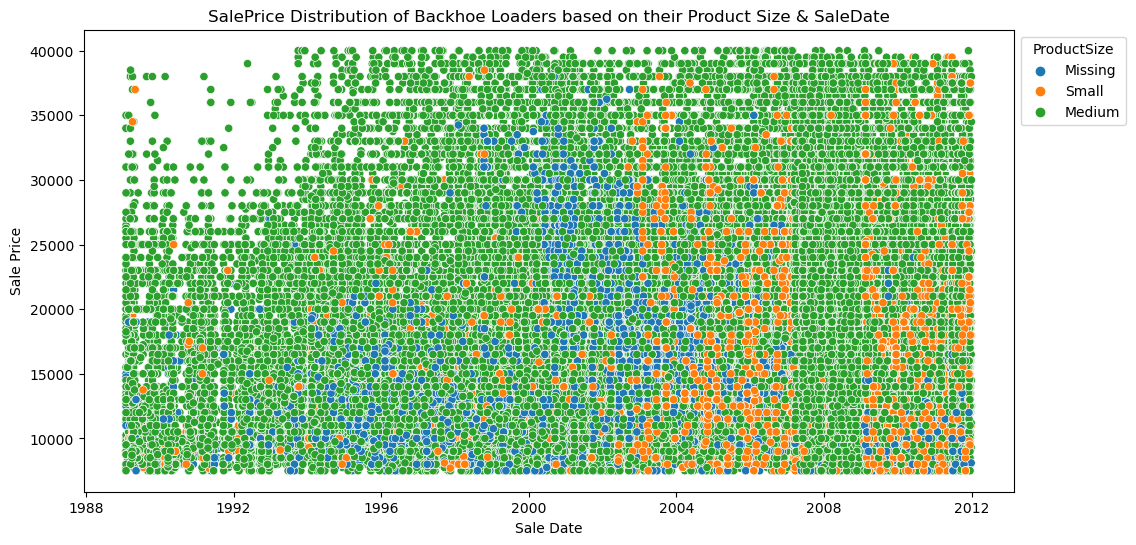

In [85]:
temp = df.copy()
temp['ProductSize'] = temp['ProductSize'].fillna('Missing')
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(x=temp[temp.ProductGroupDesc == 'Backhoe Loaders'].saledate,
                y=temp[temp.ProductGroupDesc == 'Backhoe Loaders'].SalePrice,
                hue=temp[temp.ProductGroupDesc == 'Backhoe Loaders'].ProductSize,
                hue_order = ['Missing', 'Small', 'Medium'])
plt.title('SalePrice Distribution of Backhoe Loaders based on their Product Size & SaleDate')
plt.xlabel('Sale Date')
plt.ylabel('Sale Price')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1));

In [86]:
na_groups = df[df.ProductSize.isna()]['ProductGroupDesc'].unique().tolist()
for group in na_groups:
    mode = df[df.ProductGroupDesc == group]['ProductSize'].mode()[0]
    indices = df[df.ProductGroupDesc == group]['ProductSize'].index
    df.loc[indices, 'ProductSize'] = df[df.ProductGroupDesc == group]['ProductSize'].fillna(mode)

In [118]:
cols_to_cat.update({'ProductGroupDesc', 'ProductSize'})

### Inspecting Drive_System

In [87]:
df.Drive_System.value_counts(dropna=False)

Drive_System
NaN                 296764
Two Wheel Drive      46139
Four Wheel Drive     32996
No                   24428
All Wheel Drive        798
Name: count, dtype: int64

#### Drive System
The drive system of heavy machinery refers to how power is transmitted to the wheels or tracks of the vehicle. For the six types of equipment we have in dataset, the drive systems can vary aS follows:
1. **Wheel Loader:** Typically available in both two-wheel drive (2WD) and four-wheel drive (4WD), but `4WD is more common` due to the need for better traction and stability.
2. **Skid Steer Loaders:** Most commonly equipped with `four-wheel drive (4WD)`, but all-wheel drive (AWD) is also a term sometimes used interchangeably depending on the specific model and manufacturer.
3. **Track Excavators:** These use `tracks` instead of wheels, so the concept of wheel drive systems `doesn't apply`. Instead, they have track drives.
4. **Backhoe Loaders:** Generally available in both two-wheel drive (2WD) and four-wheel drive (4WD), with `4WD being preferred` for off-road capabilities.
5. **Track Type Tractors (Bulldozers):** These also use `tracks` instead of wheels, so they don't fit into the 2WD, 4WD, or AWD categories.
6. **Motor Graders:** Typically available in both two-wheel drive (2WD) and four-wheel drive (4WD), with `4WD versions being more common` for enhanced traction and control.

Also, paying attention to `Motor Graders` and `Backhoe Loaders`, we see that a small number of them are marked as `All Wheel Drive` which according to our research does not exist for these types of machinery, however, since there are only a few records of them, we let them AS IS.

So, we are going to treat `Drive_System` as follows:
1. Imputing missing values as highlighted above.
2. Checking whether our decision for `Backhoe Loaders` is correct.

In [88]:
pd.crosstab(df.Drive_System, df.ProductGroupDesc,dropna=False, margins=True)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Drive_System                                                           
All Wheel Drive                 4            794                   0   
Four Wheel Drive            32996              0                   0   
No                              3          24425                   0   
Two Wheel Drive             46138              1                   0   
NaN                           274            269               43488   
All                         79415          25489               43488   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  \
Drive_System                                                            
All Wheel Drive                  0                    0             0   
Four Wheel Drive                 0                    0             0   
No                               0                    0             0   
Two Wheel Drive                  0                    0             0   
NaN                         101167                80520         71046   
All                         101167                80520         71046   

ProductGroupDesc        All  
Drive_System                 
All Wheel Drive      798.00  
Four Wheel Drive  32,996.00  
No                24,428.00  
Two Wheel Drive   46,139.00  
NaN                     NaN  
All              401,125.00

In [89]:
df.Drive_System = df.Drive_System.replace('No', np.nan)

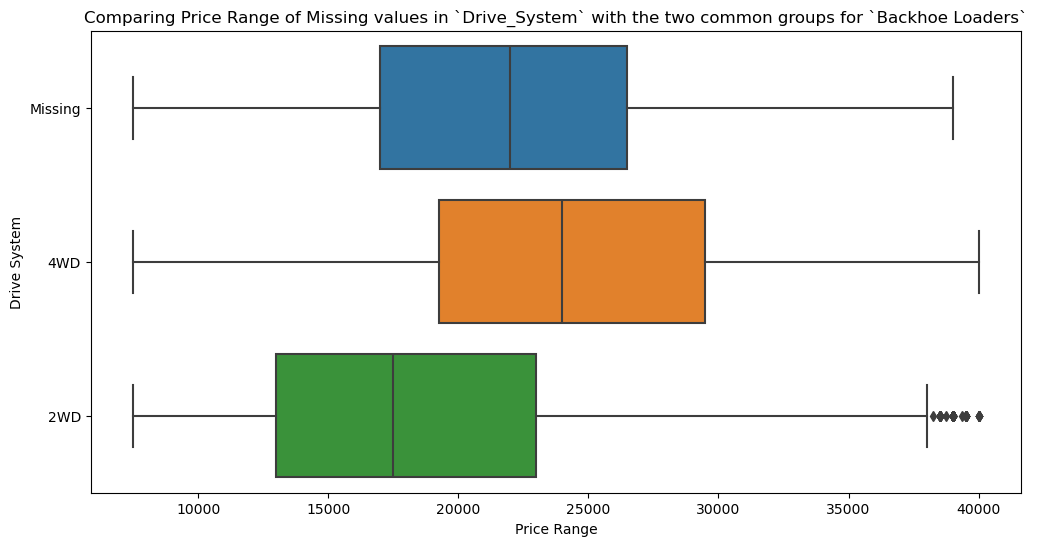

In [90]:
missing = df[(df.Drive_System.isna() == True) & (df.ProductGroupDesc == 'Backhoe Loaders')]['SalePrice']
fourw = df[(df.Drive_System == 'Four Wheel Drive') & (df.ProductGroupDesc == 'Backhoe Loaders')]['SalePrice']
twow = df[(df.Drive_System == 'Two Wheel Drive') & (df.ProductGroupDesc == 'Backhoe Loaders')]['SalePrice']

box_data = pd.DataFrame({'Price Range': pd.concat([missing, fourw, twow]),
                         'Drive System': ['Missing']*len(missing)+['4WD']*len(fourw)+['2WD']*len(twow)})
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='Price Range', y='Drive System', data=box_data)
plt.title('Comparing Price Range of Missing values in `Drive_System` with the two common groups for `Backhoe Loaders`');

In [91]:
ds_mapping = {'Wheel Loader': 'Four Wheel Drive',
              'Track Type Tractors': 'Tracks',
              'Track Excavators':'Tracks',
              'Skid Steer Loaders': 'Four Wheel Drive',
              'Motor Graders': 'Four Wheel Drive',
              'Backhoe Loaders': 'Four Wheel Drive'}

def ds_imputer(row):
    if pd.isna(row.Drive_System):
        return ds_mapping[row.ProductGroupDesc]
    else:
        return row.Drive_System
df.Drive_System = df.apply(ds_imputer, axis=1)

In [120]:
cols_to_cat.add('Drive_System')

### Inspecting Enclosure & Enclosure_Type

In [92]:
df.Enclosure.value_counts(dropna=False)

Enclosure
OROPS         173932
EROPS         139026
EROPS w AC     87820
NaN              327
EROPS AC          17
NO ROPS            3
Name: count, dtype: int64

#### Enclosure
The enclosure type of heavy equipment refers to the operator's cabin and the level of protection it provides. Here’s a breakdown of the enclosures:

* **EROPS (Enclosed Rollover Protective Structure):** A protective cabin that encloses the operator, providing protection against rollovers and environmental elements.
* **EROPS w AC / EROPS AC:** An EROPS enclosure with air conditioning. These terms can be considered the same as they both indicate an enclosed cabin with AC.
* **OROPS (Open Rollover Protective Structure):** A protective frame around the operator's seat that provides protection against rollovers but does not enclose the operator.
* **NO ROPS:** Indicates the equipment lacks a rollover protective structure.
* **None or Unspecified:** Indicates that no specific information is provided about the enclosure, which might imply no ROPS or that the data is missing.

Enclosures for Each Equipment Type:
* **Wheel Loader:** Can have EROPS (with or without AC) or `OROPS`.
* **Skid Steer Loaders:** Typically have EROPS or `OROPS`, with enclosed versions often having AC.
* **Track Excavators:** Usually have `EROPS` (with or without AC) due to the nature of their work environment.
* **Backhoe Loaders:** Can have EROPS (with or without AC) or `OROPS`.
* **Track Type Tractors (Bulldozers):** Usually have `EROPS` (with or without AC) for protection in harsh conditions.
* **Motor Graders:** Typically have `EROPS` (with or without AC) or OROPS.

Conclusion:
* `OROPS` is a common option for Wheel Loaders, Skid Steer Loaders, Backhoe Loaders, and Motor Graders
* Track Excavators and Track Type Tractors are generally provided with `EROPS` due to safety and environmental protection needs.
* `NO ROPS` is uncommon for modern equipment, might be found in older models or certain types of specialized machinery.

Here's how we are going to Handle the Missing Values/Erroneous types:
1. Combine `EROPS w AC` and `EROPS AC` together
2. Change `None or Unspecified` to `NaN`
3. Check whether we should combine `EROPS w AC` with `EROPS`
4. Change all `NaN` values to the above highlights

In [93]:
pd.crosstab(df.Enclosure, df.ProductGroupDesc, dropna=False, margins=True)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Enclosure                                                              
EROPS                       20787          13237                2120   
EROPS AC                        1              3                   1   
EROPS w AC                   7002           7830                1462   
NO ROPS                         0              0                   0   
OROPS                       51617           4419               39905   
NaN                             8              0                   0   
All                         79415          25489               43488   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  \
Enclosure                                                               
EROPS                        65158                 8130         29594   
EROPS AC                         3                    4             5   
EROPS w AC                   35460                13059         23007   
NO ROPS                          0                    3             0   
OROPS                          429                59188         18374   
NaN                            117                  136            66   
All                         101167                80520         71046   

ProductGroupDesc        All  
Enclosure                    
EROPS            139,026.00  
EROPS AC              17.00  
EROPS w AC        87,820.00  
NO ROPS                3.00  
OROPS            173,932.00  
NaN                     NaN  
All              401,125.00

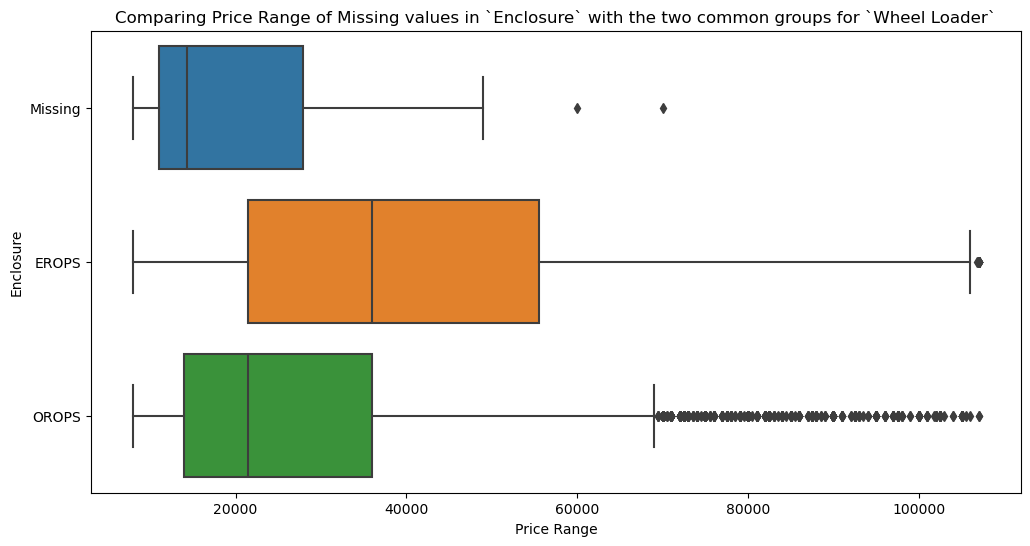

In [94]:
missing = df[(df.Enclosure.isna() == True) & (df.ProductGroupDesc == 'Wheel Loader')]['SalePrice']
EROPS = df[((df.Enclosure == 'EROPS') |  (df.Enclosure == 'EROPS w AC')) & (df.ProductGroupDesc == 'Wheel Loader')]['SalePrice']
OROPS = df[(df.Enclosure == 'OROPS') & (df.ProductGroupDesc == 'Wheel Loader')]['SalePrice']

box_data = pd.DataFrame({'Price Range': pd.concat([missing, EROPS, OROPS]),
                         'Enclosure': ['Missing']*len(missing)+['EROPS']*len(EROPS)+['OROPS']*len(OROPS)})
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='Price Range', y='Enclosure', data=box_data)
plt.title('Comparing Price Range of Missing values in `Enclosure` with the two common groups for `Wheel Loader`');

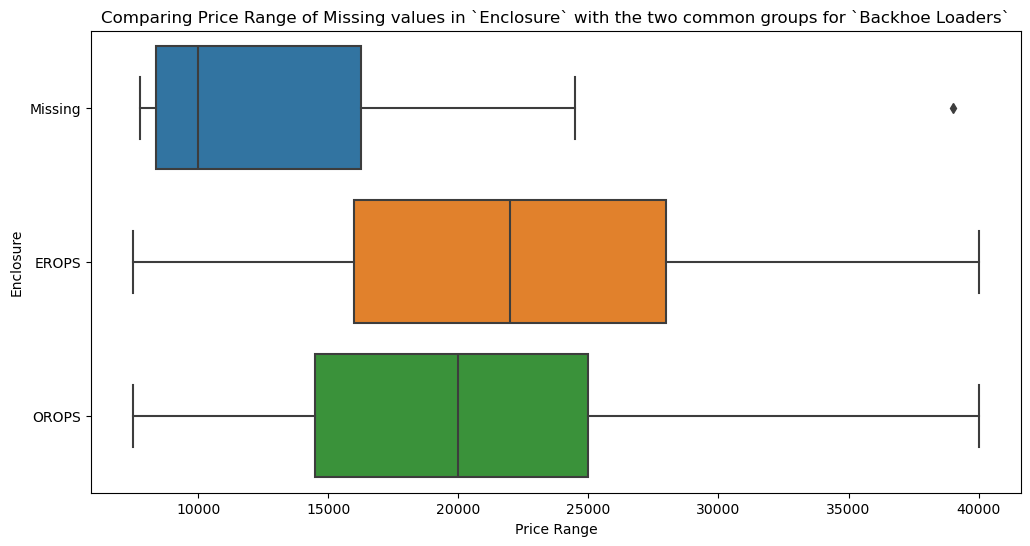

In [95]:
missing = df[(df.Enclosure.isna() == True) & (df.ProductGroupDesc == 'Backhoe Loaders')]['SalePrice']
EROPS = df[((df.Enclosure == 'EROPS') |  (df.Enclosure == 'EROPS w AC')) & (df.ProductGroupDesc == 'Backhoe Loaders')]['SalePrice']
OROPS = df[(df.Enclosure == 'OROPS') & (df.ProductGroupDesc == 'Backhoe Loaders')]['SalePrice']

box_data = pd.DataFrame({'Price Range': pd.concat([missing, EROPS, OROPS]),
                         'Enclosure': ['Missing']*len(missing)+['EROPS']*len(EROPS)+['OROPS']*len(OROPS)})
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='Price Range', y='Enclosure', data=box_data)
plt.title('Comparing Price Range of Missing values in `Enclosure` with the two common groups for `Backhoe Loaders`');

In [96]:
df.Enclosure = df.Enclosure.replace('EROPS AC', 'EROPS w AC')

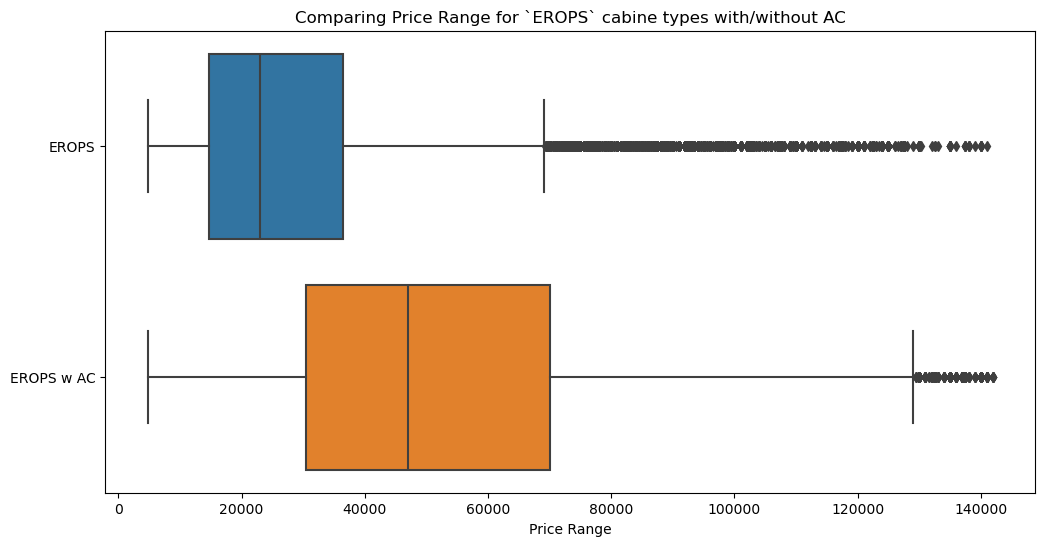

In [97]:
EROPS = df[df.Enclosure == 'EROPS']['SalePrice']
EROPSAC = df[df.Enclosure == 'EROPS w AC']['SalePrice']

box_data = pd.DataFrame({'Price Range': pd.concat([EROPS, EROPSAC]),
                         'Enclosure': ['EROPS']*len(EROPS)+['EROPS w AC']*len(EROPSAC)})
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='Price Range', y='Enclosure', data=box_data)
plt.title('Comparing Price Range for `EROPS` cabine types with/without AC')
plt.ylabel('');

In [98]:
en_mapping = {'Wheel Loader': 'OROPS',
              'Track Type Tractors': 'EROPS',
              'Track Excavators':'EROPS',
              'Skid Steer Loaders': 'OROPS',
              'Motor Graders': 'EROPS',
              'Backhoe Loaders': 'OROPS'}
def en_imputer(row):
    if pd.isna(row.Enclosure):
        return en_mapping[row.ProductGroupDesc]
    else:
        return row.Enclosure
df.Enclosure = df.apply(en_imputer, axis=1)

In [99]:
df.Enclosure_Type.value_counts(dropna=False)

Enclosure_Type
NaN             397829
Low Profile       2510
High Profile       786
Name: count, dtype: int64

#### Enclosure_Type (binary)
The term "Enclosure Type" generally refers to the design and configuration of the operator's cabin or protective structure. 

* **Low Profile:** A design where the operator’s cabin or protective structure is lower to the ground, which can be beneficial for working in areas with height restrictions or where a lower center of gravity is advantageous. More common in `compact equipment` like Skid Steer Loaders and some Wheel Loaders.
* **High Profile:** A design where the operator’s cabin or protective structure is elevated, providing better visibility for the operator and often used in applications where height is not a restriction. Common across most types of heavy equipment, including Wheel Loaders, Track Excavators, Backhoe Loaders, Track Type Tractors, and Motor Graders due to the need for improved operator visibility.

Enclosure Types for Each Equipment Type:
* **Wheel Loader:** Typically can have both low profile and high profile enclosures depending on the model and intended use.
* **Skid Steer Loaders:** Often come in both low profile and high profile variants, with `low profile` being common for `compact` models.
* **Track Excavators:** Generally have `high profile` enclosures due to the need for better visibility during digging operations.
* **Backhoe Loaders:** Can have both low profile and high profile enclosures.
* **Track Type Tractors:** Usually have `high profile` enclosures to provide better visibility and control in rugged environments.
* **Motor Graders:** Typically have `high profile` enclosures for better visibility during grading operations.

**Steps:**
1. Turn all `None or Unspecified` to `np.nan`
2. Impute Missing Values according to Machine Type

In [100]:
df.Enclosure_Type.value_counts(dropna=False)

Enclosure_Type
NaN             397829
Low Profile       2510
High Profile       786
Name: count, dtype: int64

In [101]:
pd.crosstab([df.ProductGroupDesc, df.ProductSize], df.Enclosure_Type, dropna=False, margins=True)

Enclosure_Type                   High Profile  Low Profile    NaN        All
ProductGroupDesc    ProductSize                                             
Backhoe Loaders     Compact                 0            0      0        NaN
                    Large                   0            0      0        NaN
                    Medium                  0            0  75384  75,384.00
                    Mini                    0            0      0        NaN
                    Small                   0            0   4031   4,031.00
Motor Graders       Compact                 0            0      0        NaN
                    Large                 786         2510  22193  25,489.00
                    Medium                  0            0      0        NaN
                    Mini                    0            0      0        NaN
                    Small                   0            0      0        NaN
Skid Steer Loaders  Compact                 0            0   9814   9,814.00
                    Large                   0            0      0        NaN
                    Medium                  0            0      0        NaN
                    Mini                    0            0      0        NaN
                    Small                   0            0  33674  33,674.00
Track Excavators    Compact                 0            0     38      38.00
                    Large                   0            0  49795  49,795.00
                    Medium                  0            0      0        NaN
                    Mini                    0            0  24840  24,840.00
                    Small                   0            0  26494  26,494.00
Track Type Tractors Compact                 0            0      0        NaN
                    Large                   0            0  17537  17,537.00
                    Medium                  0            0  38422  38,422.00
                    Mini                    0            0      0        NaN
                    Small                   0            0  24561  24,561.00
Wheel Loader        Compact                 0            0   6089   6,089.00
                    Large                   0            0   3438   3,438.00
                    Medium                  0            0  57831  57,831.00
                    Mini                    0            0      0        NaN
                    Small                   0            0   3688   3,688.00
All                                       786         2510      0 401,125.00

In [102]:
df.Enclosure_Type = df.apply(lambda row: 'Low Profile' if row.ProductSize in ['Compact', 'Mini', 'Small'] else 'High Profile', axis=1)

In [103]:
enc_type_mapping = {'High Profile':1, 'Low Profile':0}
df.Enclosure_Type = df.Enclosure_Type.replace(enc_type_mapping)

In [121]:
cols_to_cat.add('Enclosure')

### Inspecting Forks (binary)

Typically Have Fork Attachments:
- Wheel Loaders
- Skid Steer Loaders
- Backhoe Loaders (can have fork attachments, but not standard)

Typically Do Not Have Fork Attachments:
- Track Excavators (possible but not standard)
- Track Type Tractors
- Motor Graders


In [104]:
df.Forks.value_counts(dropna=False)

Forks
NaN    387348
Yes     13777
Name: count, dtype: int64

In [105]:
# Checking to see how the nan values are distributed
pd.crosstab(df.ProductGroupDesc, df.Forks, dropna=False, margins= True)

Forks                  Yes     NaN     All
ProductGroupDesc                          
Backhoe Loaders       3016   76399   79415
Motor Graders            0   25489   25489
Skid Steer Loaders     796   42692   43488
Track Excavators         0  101167  101167
Track Type Tractors      0   80520   80520
Wheel Loader          9965   61081   71046
All                  13777       0  401125

In [106]:
df.Forks = df.apply(lambda row: 'Yes' if row.ProductGroupDesc in ['Backhoe Loaders', 'Skid Steer Loaders', 'Wheel Loade'] else 'No', axis=1)

In [107]:
fork_mapping = {'Yes':1, 'No':0}
df.Forks = df.Forks.replace(fork_mapping)

### Inspecting Pad_Type, Track_Type, Grouser_Type, & Grouser_Tracks

**Pad Type**

Pad Type refers to the type of tracks or pads used on the undercarriage of tracked machinery. Pads are the individual segments that come into contact with the ground and provide traction, stability, and durability to the machine. The main types of pads include:

- **Reversible Pads:** Can be reversed to extend their lifespan, commonly used in applications where frequent wear is expected.
- **Street Pads:** Rubber pads designed to minimize damage to paved surfaces, ideal for urban environments.
- **Grouser Pads:** Metal pads with protruding ribs or "grousers" that provide extra traction in rough or uneven terrain, commonly used in heavy construction and mining.

For the majority of the product groups, particularly those with wheels (Wheel Loaders, Skid Steer Loaders, Backhoe Loaders, Motor Graders), pad types are generally `Not Applicable`. Track-based machinery like Track Excavators and Track Type Tractors have specific pad types depending on the application.

1. **Track Excavators**
    - **Mini (Compact):** Typically use rubber `street pads` for urban and landscaping tasks.
    - **Small to Medium:** Can use `either` rubber street pads or grouser pads depending on the application (urban vs. rough terrain).
    - **Large to Very Large:** More likely to use `grouser pads` for heavy-duty and rough terrain applications.
2. **Track Type Tractors**
    - **Small:** May use `street pads (rubber)` for lighter and urban tasks.
    - **Medium:** Typically use `grouser pads` for medium to heavy construction.
    - **Large to Very Large:** Almost exclusively use `grouser pads` for heavy-duty construction and mining.

---
**Track Type**

Pad Type and Track Type are closely related features in crawler machines. The Pad Type refers to the specific design of the pads that are attached to the tracks, while the Track Type indicates whether the tracks are made of rubber or steel. - **Rubber Tracks** : If a machine has a pad type associated with rubber, sucs as `Street pads`, it’s likely to have rubber tracks
- **Steel Tracks**: If a machine has `Grousee pads` or `Reversible pads`, it’s likely to have steel tracks.

---
**Grouser_Tracks (Binary)**

It will be reflected in `Grouser Type` so we won't need to deel with this feature except if it helps us fill some missing values in other features in this group.

---
**Grouser_Type**

Grouser Type refers to the design of the raised bars (grousers) on the track pads of a crawler machine. These grousers provide traction by digging into the ground as the machine moves. Steel tracks might have single, double, or triple grousers, whereas rubber tracks typically do not have grousers or might have specialized patterns instead.
- **Single:** Used in heavy-duty applications like bulldozers and some track-type tractors.
- **Double:** Commonly found on excavators and some loaders.
- **Triple:** Often seen on track loaders and some excavators.

---
**Steps:**
1. Check out the distribution of Missing Values according to Size & Grouser Type & Track Type
2. `Backhoe Loaders` seems to have erronoeus data, prior to turning them into industry norm value (`Not Applicable`), we check with `Grouser_Type`, `Grouser_Tracks`, & `Track_Type`
3. Turn all Nan values in Pad_Type, Track_Type, Grouser_Type, and Grouser_Tracks into `Not Applicable` for products that have wheels to get access to true missing values and eliminate the effect of ProductGroupDesc from our Missing Value analysis
4. Fill the Missing values of `Track_Type` and `Grouser_Type` according to the most frequent value in their peer groupe and the rest with industry norm

#### Grouser_Tracks

In [108]:
pd.crosstab(df.ProductGroupDesc, [df.Grouser_Type,df.Pad_Type], dropna=False).T

ProductGroupDesc         Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Grouser_Type Pad_Type                                                         
Double       Grouser                   0              0                   0   
             Reversible                0              0                   0   
             Street                    0              0                   0   
             NaN                       0              0                   0   
Single       Grouser                   0              0                   0   
             Reversible                0              0                   0   
             Street                    0              0                   0   
             NaN                       0              0                   0   
Triple       Grouser                   0              0                   0   
             Reversible                0              0                   0   
             Street                    0              0                   0   
             NaN                       0              0                   0   
NaN          Grouser                  25              0                   0   
             Reversible             5832              0                   0   
             Street                 2663              0                   0   
             NaN                   70895          25489               43488   

ProductGroupDesc         Track Excavators  Track Type Tractors  Wheel Loader  
Grouser_Type Pad_Type                                                         
Double       Grouser                    0                    0             0  
             Reversible                 0                    0             0  
             Street                     0                    0             0  
             NaN                    84653                    0             0  
Single       Grouser                    0                    0             0  
             Reversible                 0                    0             0  
             Street                     0                    0             0  
             NaN                        2                    0             0  
Triple       Grouser                    0                    0             0  
             Reversible                 0                    0             0  
             Street                     0                    0             0  
             NaN                    14498                    0             0  
NaN          Grouser                    0                    0             0  
             Reversible                 0                    0             0  
             Street                     0                    0             0  
             NaN                     2014                80520         71046

In [109]:
pd.crosstab(df.ProductGroupDesc, [df.Grouser_Tracks,df.Pad_Type], dropna=False).T

ProductGroupDesc           Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Grouser_Tracks Pad_Type                                                         
Yes            Grouser                   0              0                   0   
               Reversible                0              0                   0   
               Street                    0              0                   0   
               NaN                       0              0                2847   
NaN            Grouser                  25              0                   0   
               Reversible             5832              0                   0   
               Street                 2663              0                   0   
               NaN                   70895          25489               40641   

ProductGroupDesc           Track Excavators  Track Type Tractors  Wheel Loader  
Grouser_Tracks Pad_Type                                                         
Yes            Grouser                    0                    0             0  
               Reversible                 0                    0             0  
               Street                     0                    0             0  
               NaN                        0                    0             0  
NaN            Grouser                    0                    0             0  
               Reversible                 0                    0             0  
               Street                     0                    0             0  
               NaN                   101167                80520         71046

In [110]:
columns = ['Pad_Type', 'Track_Type', 'Grouser_Type', 'Grouser_Tracks']
def pad_imputer(row, col):
    if row.ProductGroupDesc in ['Wheel Loader', 'Skid Steer Loaders', 'Motor Graders', 'Backhoe Loaders']:
        return 'Not Applicable'
    elif isinstance(row[col], str):
        return row[col]
    else:
        return np.nan

In [111]:
for col in columns:
    df[col] = df.apply(lambda row: pad_imputer(row, col), axis=1)

In [112]:
df[columns].isna().sum().sort_values()

Track_Type         82534
Grouser_Type       82534
Pad_Type          181687
Grouser_Tracks    181687
dtype: int64

In [113]:
pd.crosstab(df.Grouser_Type ,df.Track_Type, dropna=False, margins=True).T

Grouser_Type      Double  Not Applicable  Single    Triple       NaN  \
Track_Type                                                             
Not Applicable      0.00      219,438.00    0.00      0.00      0.00   
Rubber         14,070.00            0.00    0.00    203.00      0.00   
Steel          70,583.00            0.00    2.00 14,295.00      0.00   
NaN                 0.00            0.00    0.00      0.00 82,534.00   
All            84,653.00      219,438.00    2.00 14,498.00       NaN   

Grouser_Type          All  
Track_Type                 
Not Applicable 219,438.00  
Rubber          14,273.00  
Steel           84,880.00  
NaN                  0.00  
All            401,125.00

In [114]:
common_track_types  = df[(df['Track_Type'].notna()) & (df.ProductGroupDesc.isin(['Track Excavators', 'Track Type Tractors']))].groupby(['ProductGroupDesc', 'ProductSize'])['Track_Type'].agg(lambda x: x.value_counts().index[0]).to_dict()
common_track_types.update({('Track Excavators', 'Medium'):'Steel',
                           ('Track Type Tractors', 'Small'): 'Rubber',
                           ('Track Type Tractors', 'Mini'): 'Rubber',
                           ('Track Type Tractors', 'Compact'): 'Rubber',
                           ('Track Type Tractors', 'Medium'):'Steel',
                           ('Track Type Tractors', 'Large'):'Steel'}
                         )

In [115]:
def track_imputer(row, mapper):
    key = (row.ProductGroupDesc, row.ProductSize)
    
    if isinstance(row.Track_Type, str):
        return row.Track_Type
    elif row.ProductGroupDesc in ['Wheel Loader', 'Skid Steer Loaders', 'Motor Graders', 'Backhoe Loaders']:
        return 'Not Applicable'
    return mapper.get(key, np.nan)

In [116]:
df.Track_Type = df.apply(lambda row: track_imputer(row, common_track_types), axis=1)

#### Grouser_Type

In [117]:
pd.crosstab(df.Grouser_Type ,df.Track_Type, dropna=False, margins=True).T

Grouser_Type      Double  Not Applicable  Single    Triple       NaN  \
Track_Type                                                             
Not Applicable      0.00      219,438.00    0.00      0.00      0.00   
Rubber         14,070.00            0.00    0.00    203.00 25,028.00   
Steel          70,583.00            0.00    2.00 14,295.00 57,506.00   
All            84,653.00      219,438.00    2.00 14,498.00       NaN   

Grouser_Type          All  
Track_Type                 
Not Applicable 219,438.00  
Rubber          39,301.00  
Steel          142,386.00  
All            401,125.00

In [122]:
common_grouser_type = df[(df.ProductGroupDesc.isin(['Track Excavators', 'Track Type Tractors'])) & (df.Grouser_Type.notna())].groupby(['ProductGroupDesc', 'ProductSize'])['Grouser_Type'].agg(lambda x: x.value_counts().index[0]).to_dict()

In [123]:
def grouser_imputer(row, mapper):
    key = (row.ProductGroupDesc, row.ProductSize)
    if row.Track_Type == 'Rubber':
        return 'Not Applicable'
    elif isinstance(row.Grouser_Type, str):
        return row.Grouser_Type
    elif row.ProductGroupDesc in ['Wheel Loader', 'Skid Steer Loaders', 'Motor Graders', 'Backhoe Loaders']:
        return 'Not Applicable'
    elif row.ProductGroupDesc == 'Track Excavators':
        return 'Double'
    elif row.ProductGroupDesc == 'Track Type Tractors':
        return 'Single'
    return common_grouser_type.get(key, np.nan)

In [124]:
df.Grouser_Type = df.apply(lambda row: grouser_imputer(row, common_grouser_type), axis=1)

#### Pad_Type

In [126]:
def pad_type_imputer(row):
    if isinstance(row.Pad_Type, str):
        return row.Pad_Type
    elif row.Track_Type == 'Steel':
        return 'Grouser'
    elif row.Track_Type == 'Rubber':
        return 'Street'
    else:
        return np.nan

In [127]:
df.Pad_Type = df.apply(lambda row: pad_type_imputer(row), axis=1)

In [125]:
cols_to_del.add('Grouser_Tracks')
cols_to_cat.update({'Pad_Type', 'Grouser_Type', 'Track_Type'})

### Inspecting Ride_Control (bianary)

Ride Control is a feature in heavy machinery designed to improve operator comfort and machine stability by smoothing out the ride over rough terrain. It typically involves hydraulic or electronic systems that absorb shocks and reduce machine bounce, which can enhance productivity, extend the life of the machine, and reduce operator fatigue.

For Wheel Loader, Backhoe Loaders, & Motor Graders:
- Large & Medium sizes come with a ride control
- Small, Compact, and Mini sizes don't necessarily have ride control

For Skid Steer Loaders, Track Excavators, & Track Type Tractors, they rarely come with a ride control.

In [128]:
df.Ride_Control.value_counts(dropna=False)

Ride_Control
NaN    315635
No      77685
Yes      7805
Name: count, dtype: int64

In [129]:
pd.crosstab([df.ProductGroupDesc, df.ProductSize], df.Ride_Control, dropna=False, margins=True)

Ride_Control                        No   Yes    NaN        All
ProductGroupDesc    ProductSize                               
Backhoe Loaders     Compact          0     0      0        NaN
                    Large            0     0      0        NaN
                    Medium       73594  1524    266  75,384.00
                    Mini             0     0      0        NaN
                    Small         3957    59     15   4,031.00
Motor Graders       Compact          0     0      0        NaN
                    Large            0     0  25489  25,489.00
                    Medium           0     0      0        NaN
                    Mini             0     0      0        NaN
                    Small            0     0      0        NaN
Skid Steer Loaders  Compact          0     0   9814   9,814.00
                    Large            0     0      0        NaN
                    Medium           0     0      0        NaN
                    Mini             0     0      0        NaN
                    Small            0     0  33674  33,674.00
Track Excavators    Compact          0     0     38      38.00
                    Large            0     0  49795  49,795.00
                    Medium           0     0      0        NaN
                    Mini             0     0  24840  24,840.00
                    Small            0     0  26494  26,494.00
Track Type Tractors Compact          0     0      0        NaN
                    Large            0     0  17537  17,537.00
                    Medium           0     0  38422  38,422.00
                    Mini             0     0      0        NaN
                    Small            0     0  24561  24,561.00
Wheel Loader        Compact         44    37   6008   6,089.00
                    Large            2    80   3356   3,438.00
                    Medium          76  6043  51712  57,831.00
                    Mini             0     0      0        NaN
                    Small           12    62   3614   3,688.00
All                              77685  7805      0 401,125.00

In [130]:
def ride_control(row):
    if not pd.isna(row.Ride_Control):
        return row.Ride_Control
    else:
        if row.ProductGroupDesc in ['Track Type Tractors', 'Track Excavators', 'Skid Steer Loaders']:
            return 'No'
        elif row.ProductGroupDesc in ['Backhoe Loaders', 'Wheel Loader', 'Motor Graders'] and row.ProductSize in ['Large', 'Medium']:
            return 'Yes'
        elif row.ProductGroupDesc in ['Backhoe Loaders', 'Wheel Loader', 'Motor Graders'] and row.ProductSize in ['Small', 'Mini', 'Compact']:
            return 'No'

In [131]:
df.Ride_Control = df.apply(ride_control, axis=1)

In [132]:
ride_control_mapping = {'Yes':1, 'No':0}
df.Ride_Control = df.Ride_Control.replace(ride_control_mapping)

### Inspecting Stick & Stick_Length

**Don't Have Stick:**
- Wheel Loader
- Skid Steer Loader
- Track Type Tractor
- Motor Graders

**Have Stick:**
- Track Excavators: Track excavators come with either a standard or extended stick, depending on the reach and digging depth required. Mini & Small ones use a `Standard` stick, and Medium and Large sizes come with an `Extended` version.
- Backhoe Loader: Backhoe loaders can come with either a standard or extended stick. Larger backhoe loaders are more likely to have the option for an `extended` stick, while smaller models typically use a `standard` stick.

- **Track Excavators**
    - **Standard Stick:**
        - Mini and Small: 6 to 10 feet
        - Medium: 10 to 15 feet
        - Large: 15 to 20 feet
        - Very Large: 20+ feet
    - **Extended Stick:**
        - Mini and Small: 10 to 15 feet
        - Medium: 15 to 20 feet
        - Large: 20 to 25 feet
        - Very Large: 25+ feet
- **Backhoe Loaders**
    - **Standard Stick:**
        - Compact and Small: 10 to 12 feet
        - Medium: 12 to 14 feet
    - **Extended Stick:**
        - Compact and Small: 14 to 16 feet
        - Medium: 16 to 18 feet
     
**Steps:**
1. Extract the `Foot` value from `Stick_Length`
2. First, Impute the `Stick` Missing Values that have a value in `Stick_Length` according to the above breakdown
3. Next, Impute the rest of `Stick` missing values according to the earlier category.
4. Since `Stick Length` is explained through `ProductSize`, `ProductGroupDesc`, & `Stick`, we can safely remove it from our dataset.

In [133]:
df.Stick.value_counts(dropna=False)

Stick
NaN         321991
Standard     48829
Extended     30305
Name: count, dtype: int64

In [134]:
pd.crosstab([df.ProductGroupDesc, df.ProductSize], df.Stick, dropna=False, margins=True)

Stick                            Extended  Standard    NaN        All
ProductGroupDesc    ProductSize                                      
Backhoe Loaders     Compact             0         0      0        NaN
                    Large               0         0      0        NaN
                    Medium          29184     45934    266  75,384.00
                    Mini                0         0      0        NaN
                    Small            1121      2895     15   4,031.00
Motor Graders       Compact             0         0      0        NaN
                    Large               0         0  25489  25,489.00
                    Medium              0         0      0        NaN
                    Mini                0         0      0        NaN
                    Small               0         0      0        NaN
Skid Steer Loaders  Compact             0         0   9814   9,814.00
                    Large               0         0      0        NaN
                    Medium              0         0      0        NaN
                    Mini                0         0      0        NaN
                    Small               0         0  33674  33,674.00
Track Excavators    Compact             0         0     38      38.00
                    Large               0         0  49795  49,795.00
                    Medium              0         0      0        NaN
                    Mini                0         0  24840  24,840.00
                    Small               0         0  26494  26,494.00
Track Type Tractors Compact             0         0      0        NaN
                    Large               0         0  17537  17,537.00
                    Medium              0         0  38422  38,422.00
                    Mini                0         0      0        NaN
                    Small               0         0  24561  24,561.00
Wheel Loader        Compact             0         0   6089   6,089.00
                    Large               0         0   3438   3,438.00
                    Medium              0         0  57831  57,831.00
                    Mini                0         0      0        NaN
                    Small               0         0   3688   3,688.00
All                                 30305     48829      0 401,125.00

In [135]:
# Check to see if there are any `Stick_Length` measurements available for missing values in `Stick`
df[(pd.isna(df.Stick))&(~ (pd.isna(df.Stick_Length)))].Stick_Length

12        11' 0"
29        15' 9"
68        11' 0"
71        10' 2"
123       10' 2"
           ...  
400642     9' 8"
400661    10' 6"
400671    12' 8"
400676    11' 0"
400678    11' 0"
Name: Stick_Length, Length: 20398, dtype: object

In [136]:
# Extract Foot Value of Stick_Length
df.Stick_Length = df.Stick_Length.apply(lambda x: int(x.split("'")[0]) if isinstance(x, str) else np.nan)

In [137]:
stick_mapping = {('Small', 'Track Excavators'):{10: 'Standard', 15: 'Extended'},
                 ('Mini', 'Track Excavators'):{10: 'Standard', 15: 'Extended'},
                 ('Medium', 'Track Excavators'):{15: 'Standard', 20: 'Extended'},
                 ('Large', 'Track Excavators'):{20: 'Standard', 25: 'Extended'},
                 ('Small', 'Backhoe Loaders'):{12: 'Standard', 16: 'Extended'},
                 ('Compact', 'Backhoe Loaders'):{12: 'Standard', 16: 'Extended'},
                 ('Medium', 'Backhoe Loaders'):{14: 'Standard', 18: 'Extended'}}

In [138]:
def stick_imputer(row, mapper):
    key = (row.ProductSize, row.ProductGroupDesc)
    stick_length = row.Stick_Length

    if isinstance(row.Stick, str):
        return row.Stick
    
    elif pd.notna(row.Stick_Length) and key in mapper:
        for upper_bound in sorted(mapper[key].keys()):
            if stick_length <= upper_bound:
                return mapper[key][upper_bound]
            else:
                return 'Extended'
    
    elif row.ProductGroupDesc in ['Track Excavators', 'Backhoe Loaders'] and row.ProductSize in ['Mini', 'Compact', 'Small']:
        return 'Standard'
    
    elif row.ProductGroupDesc in ['Track Excavators', 'Backhoe Loaders'] and row.ProductSize in ['Medium', 'Large']:
        return 'Extended'
    
    elif row.ProductGroupDesc in ['Wheel Loader', 'Skid Steer Loaders', 'Track Type Tractors', 'Motor Graders']:
        return 'Not Applicable'

In [139]:
df.Stick = df.apply(lambda row: stick_imputer(row, stick_mapping), axis=1)

In [141]:
cols_to_del.add('Stick_Length')
cols_to_cat.add('Stick')

### Inspecting Transmission

**Types of Transmission:**
- **Standard:** Also known as manual transmissions, require the operator to manually shift gears to control the speed and direction of the equipment.
- **Powershift:** Powershift transmissions are automatic transmissions that allow for quick and smooth shifting between gears without interrupting power delivery to the wheels or tracks.
- **Powershuttle:** Powershuttle transmissions are a variation of powershift transmissions that incorporate a shuttle or direction-reversing mechanism, allowing the operator to quickly and smoothly change direction without using the clutch. Powershuttle transmissions are `commonly found in backhoe loaders` and similar equipment where frequent changes in direction are required, such as loading and excavation tasks.
- **Hydrostatic:** Hydrostatic transmissions use hydraulic fluid to transmit power from the engine to the wheels or tracks, providing infinitely variable speed control and precise maneuverability. Hydrostatic transmissions are popular in `compact` and maneuverable equipment such as `skid steer loaders`, where precise control and smooth operation are essential for tasks in confined spaces and delicate environments.
- **Direct Drive:** Also known as mechanical transmissions, provide a direct connection between the engine and the wheels or tracks without the use of a torque converter or other power-shifting mechanism. Direct drive transmissions are `less common` in heavy equipment compared to other transmission types.
- **Autoshift:**  Autoshift transmissions are automatic transmissions equipped with advanced electronic controls that automatically select the appropriate gear based on operating conditions, load, and terrain.

**Transmission per Product Group:**
1. **Wheel Loaders**
    - `Powershift` transmissions are commonly used in larger wheel loaders for heavy-duty tasks in construction, mining, and material handling. `Hydrostatic` transmissions may be preferred in smaller, more maneuverable wheel loaders for applications requiring precise control and versatility.
2. **Skid Steer Loaders**: `Hydrostatic` transmissions are the predominant choice for skid steer loaders due to their compact size, maneuverability, and need for precise control in confined spaces.
3. **Track Excavators**: `Hydrostatic` transmissions are widely used in track excavators for smooth and precise operation during digging, lifting, and material handling tasks. They provide excellent control and efficiency in various operating conditions.
4. **Backhoe Loaders**: `Powershift` transmissions are commonly found in backhoe loaders, providing efficient power delivery and versatility for digging, loading, and material handling operations. Powershuttle transmissions may also be used for quick and smooth direction changes.
5. **Track Type Tractors**: Larger track type tractors often utilize `Powershift` transmissions for heavy-duty earthmoving and construction tasks. `Hydrostatic` transmissions may be preferred in smaller models for precise control and maneuverability.
6. **Motor Graders**: `Powershift` transmissions are commonly used in motor graders for efficient power delivery and smooth operation during grading and leveling tasks. Standard transmissions may also be found in certain models for specific applications.

In [142]:
df.Transmission.value_counts(dropna=False)

Transmission
NaN             241042
Standard        140328
Powershift       11731
Powershuttle      4244
Hydrostatic       3204
Direct Drive       418
Autoshift          114
AutoShift           44
Name: count, dtype: int64

In [143]:
df.Transmission = df.Transmission.replace('Autoshift', 'AutoShift')

In [144]:
pd.crosstab(df.Transmission, [df.ProductGroupDesc, df.ProductSize], dropna=False, margins=True).T

Transmission                     AutoShift  Direct Drive  Hydrostatic  \
ProductGroupDesc    ProductSize                                         
Backhoe Loaders     Compact           0.00          0.00         0.00   
                    Large             0.00          0.00         0.00   
                    Medium          114.00          0.00        48.00   
                    Mini              0.00          0.00         0.00   
                    Small             0.00          0.00       225.00   
Motor Graders       Compact           0.00          0.00         0.00   
                    Large            44.00          0.00         1.00   
                    Medium            0.00          0.00         0.00   
                    Mini              0.00          0.00         0.00   
                    Small             0.00          0.00         0.00   
Skid Steer Loaders  Compact           0.00          0.00         0.00   
                    Large             0.00          0.00         0.00   
                    Medium            0.00          0.00         0.00   
                    Mini              0.00          0.00         0.00   
                    Small             0.00          0.00         0.00   
Track Excavators    Compact           0.00          0.00         0.00   
                    Large             0.00          0.00         0.00   
                    Medium            0.00          0.00         0.00   
                    Mini              0.00          0.00         0.00   
                    Small             0.00          0.00         0.00   
Track Type Tractors Compact           0.00          0.00         0.00   
                    Large             0.00         63.00        48.00   
                    Medium            0.00        154.00     1,475.00   
                    Mini              0.00          0.00         0.00   
                    Small             0.00        201.00     1,407.00   
Wheel Loader        Compact           0.00          0.00         0.00   
                    Large             0.00          0.00         0.00   
                    Medium            0.00          0.00         0.00   
                    Mini              0.00          0.00         0.00   
                    Small             0.00          0.00         0.00   
All                                 158.00        418.00     3,204.00   

Transmission                     Powershift  Powershuttle   Standard  \
ProductGroupDesc    ProductSize                                        
Backhoe Loaders     Compact            0.00          0.00       0.00   
                    Large              0.00          0.00       0.00   
                    Medium           972.00      4,037.00  70,008.00   
                    Mini               0.00          0.00       0.00   
                    Small             30.00        206.00   3,555.00   
Motor Graders       Compact            0.00          0.00       0.00   
                    Large          2,086.00          0.00      38.00   
                    Medium             0.00          0.00       0.00   
                    Mini               0.00          0.00       0.00   
                    Small              0.00          0.00       0.00   
Skid Steer Loaders  Compact            0.00          0.00       0.00   
                    Large              0.00          0.00       0.00   
                    Medium             0.00          0.00       0.00   
                    Mini               0.00          0.00       0.00   
                    Small              0.00          0.00       0.00   
Track Excavators    Compact            0.00          0.00       0.00   
                    Large              0.00          0.00       0.00   
                    Medium             0.00          0.00       0.00   
                    Mini               0.00          0.00       0.00   
                    Small              0.00          0.00       0.00   
Track 

In [145]:
transmission_mapping = {'Track Excavators':'Hydrostatic',
                        'Skid Steer Loaders':'Hydrostatic',
                        'Motor Graders':'Powershift',
                        'Backhoe Loaders':'Powershift'}
def transmission_imputer(row, mapper):
    if pd.notna(row.Transmission):
        return row.Transmission
    elif row.ProductGroupDesc in mapper:
        return mapper.get(row.ProductGroupDesc)
    elif row.ProductGroupDesc in ['Wheel Loader', 'Track Type Tractors'] and row.ProductSize in ['Small', 'Mini', 'Compact']:
        return 'Hydrostatic'
    elif row.ProductGroupDesc in ['Wheel Loader', 'Track Type Tractors'] and row.ProductSize in ['Medium', 'Large']:
        return 'Powershift'

In [146]:
df.Transmission = df.apply(lambda row: transmission_imputer(row, transmission_mapping), axis=1)

In [147]:
cols_to_cat.add('Transmission')

### Inspecting Blade_Extension, Blade_Width, Blade_Type, Tip_Control

Blades are primarily associated with certain types of heavy machinery, particularly those used in grading, leveling, and earthmoving tasks.

1. **Track Type Tractors**
   - **Blade_Extension:** Commonly present in medium to very large sizes.
   - **Blade_Type:** Various types including straight, universal, and semi-U blades.
   - **Blade_Width:** Varies significantly; larger sizes can have wider blades.
   - **Tip_Control:** Important for precise control in earthmoving tasks.
2. **Motor Graders**
    - **Blade_Extension:** Typically present.
    - **Blade_Type:** Includes moldboard and other specialized grading blades.
    - **Blade_Width:** Varies, with wider blades for larger machines.
    - **Tip_Control:** Crucial for grading accuracy and precision.
3. **Backhoe Loaders**
    - **Blade_Extension:** Less common but may be present in some models.
    - **Blade_Type:** Standard types, mainly for basic grading.
    - **Blade_Width:** Smaller compared to bulldozers and motor graders.
    - **Tip_Control:** Less sophisticated compared to dedicated graders or bulldozers.
4. Wheel Loaders, Skid Steer Loaders, Track Excavators: Typically `not standard`

---
**Blade_Type**
1. Straight Blade (S-Blade): A simple, straight blade with no curvature, used for general earthmoving tasks. May have just `tip control`.
2. Angle Blade (A-Blade): A blade that can be angled to the left or right, used for pushing materials to the side. May have just `tip control`.
3. U-Blade: A curved blade that can carry more material, used for heavy-duty tasks like moving large volumes of soil or rock. Typically just `Tip control`.
4. Semi-U Blade: A combination of the straight and U-blades, used for versatile applications. Typically just `Tip control`.
5. PAT Blade (Power-Angle-Tilt): A blade that can be angled, tilted, and lifted, offering maximum flexibility. Often has `SideShift & Tip control`.
6. 6-Way Blade: A highly versatile blade that can be tilted, angled, and moved in multiple directions. Often has `SideShift & Tip control`.
7. V-Blade: A V-shaped blade used for snow removal and other specific tasks. Typically just `Tip control`.
8. Landfill Blade: Designed specifically for moving and compacting waste materials in landfills. Often has `SideShift & Tip control`.
9. Forestry Blade: Heavy-duty blade designed for clearing and moving forest debris. Often has `SideShift & Tip control`.
10. Coal: It is a specialized blade designed for handling coal. Typically just `Tip control`.

---
**Tip Control**

The Tip_Control feature indicates how the blade is controlled in terms of movement and positioning.
1. **SideShift & Tip Control:** Indicates the ability to both angle/tilt the blade and shift it sideways for more precise grading and earthmoving. More advanced control, likely found in machinery where precise blade positioning is critical, such as motor graders and some advanced bulldozers.
2. **Tip:** Basic blade control, common in less complex machinery or smaller models.

- **Track Type Tractors:** Both types can be present. Larger, more advanced models might have "SideShift & Tip", while smaller or older models might have just "Tip".
- **Motor Graders:** Likely to have `SideShift & Tip` due to the need for precise control in grading tasks.
- **Backhoe Loaders:** If they have blade control, it's likely to be `Tip`.

---

**Steps**:
1. Mark values in Blade_Extension, Blade_Type, Blade_Width, and Tip_Control for Wheel Loaders, Skid Steer Loaders, and Track Excavators as `Not Applicable` to get access to actual missing values
2. Change `Blade_Type` marked with `No` to `np.nan`
3. According to the relation between `Blade_Type` and `Tip_Control`, fill missing valeus of Tip_Control

In [148]:
columns = ['Blade_Extension', 'Blade_Width', 'Blade_Type', 'Tip_Control']
products = ['Wheel Loader', 'Skid Steer Loaders', 'Track Excavators']

def blade_family(row, col):
    if row.ProductGroupDesc in products:
        return 'Not Applicable'
    elif not pd.isna(row[col]):
        return row[col]
    return np.nan

for col in columns:
    df[col] = df.apply(lambda row: blade_family(row, col), axis=1)

#### Tip_Control

In [149]:
pd.crosstab(df.ProductGroupDesc,[df.Tip_Control], dropna=False)

Tip_Control          Not Applicable  Sideshift & Tip   Tip    NaN
ProductGroupDesc                                                 
Backhoe Loaders                   0                0     0  79415
Motor Graders                     0             7070  1942  16477
Skid Steer Loaders            43488                0     0      0
Track Excavators             101167                0     0      0
Track Type Tractors               0                0     0  80520
Wheel Loader                  71046                0     0      0

In [150]:
tip_control_mapping = {'PAT':'Sideshift & Tip',
                       'Semi U': 'Tip',
                       'VPAT':'Sideshift & Tip',
                       'Straight': 'Tip',
                       'Angle': 'Tip',
                       'U': 'Tip',
                       'Landfill': 'Sideshift & Tip',
                       'Coal': 'Tip'}
def tip_control(row, mapper):
    key = row.Blade_Type
    
    if isinstance(row.Tip_Control, str):
        return row.Tip_Control
    elif row.ProductGroupDesc == 'Backhoe Loaders':
        return 'Tip'
    elif row.ProductGroupDesc == 'Motor Graders':
        return 'Sideshift & Tip'
    elif row.ProductGroupDesc == 'Track Type Tractors':
        return tip_control_mapping.get(key, np.nan)
    return np.nan

df.Tip_Control = df.apply(lambda row: tip_control(row, tip_control_mapping), axis=1)

In [151]:
pd.crosstab(df.Tip_Control, df.ProductGroupDesc, dropna=False)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Tip_Control                                                            
Not Applicable                  0              0               43488   
Sideshift & Tip                 0          23547                   0   
Tip                         79415           1942                   0   
NaN                             0              0                   0   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  
Tip_Control                                                            
Not Applicable              101167                    0         71046  
Sideshift & Tip                  0                42184             0  
Tip                              0                25475             0  
NaN                              0                12861             0

In [152]:
mask = df.ProductGroupDesc == 'Track Type Tractors'
pd.crosstab(df[mask].Tip_Control, df[mask].ProductSize, dropna=False)

ProductSize      Large  Medium  Small
Tip_Control                          
Sideshift & Tip    422   21484  20278
Tip              13431   11489    555
NaN               3684    5449   3728

In [153]:
def tip_imputer(row):
    if isinstance(row.Tip_Control, str):
        return row.Tip_Control
    elif row.ProductSize == 'Large':
        return 'Sideshift & Tip'
    return 'Tip'

In [154]:
df.Tip_Control = df.apply(lambda row: tip_imputer(row), axis=1)

#### Blade_Type

In [155]:
df.Blade_Type = df.Blade_Type.replace('No', np.nan)

In [156]:
pd.crosstab(df.Blade_Type, df.ProductGroupDesc, dropna=False)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Blade_Type                                                             
Angle                           0              0                   0   
Coal                            0              0                   0   
Landfill                        0              0                   0   
Not Applicable                  0              0               43488   
PAT                             0              0                   0   
Semi U                          0              0                   0   
Straight                        0              0                   0   
U                               0              0                   0   
VPAT                            0              0                   0   
NaN                         79415          25489                   0   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  
Blade_Type                                                             
Angle                            0                 1662             0  
Coal                             0                   11             0  
Landfill                         0                   25             0  
Not Applicable              101167                    0         71046  
PAT                              0                38612             0  
Semi U                           0                 8617             0  
Straight                         0                13323             0  
U                                0                 1862             0  
VPAT                             0                 3547             0  
NaN                              0                12861             0

In [157]:
df.Blade_Type = df.Blade_Type.fillna('Straight')

In [223]:
cols_to_del.update({'Blade_Extension', 'Blade_Width'})
cols_to_cat.update({'Blade_Type', 'Tip_Control'})

### Inspecting Hydraulics & Hydraulics_Flow

In [159]:
df.Hydraulics.value_counts(dropna=False)

Hydraulics
2 Valve              141404
Standard             104423
NaN                   80565
Auxiliary             40737
Base + 1 Function     24770
3 Valve                5622
4 Valve                2960
Base + 3 Function       299
Base + 2 Function       127
Base + 5 Function        89
Base + 4 Function        76
Base + 6 Function        53
Name: count, dtype: int64

In [160]:
pd.crosstab(df.Hydraulics, df.ProductGroupDesc, dropna=False, margins=True)

ProductGroupDesc   Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Hydraulics                                                              
2 Valve                          0            103                  25   
3 Valve                          0              2                   5   
4 Valve                          0              0                   0   
Auxiliary                        0             27               14809   
Base + 1 Function                0          24575                  15   
Base + 2 Function                0            127                   0   
Base + 3 Function                0            299                   0   
Base + 4 Function                0             76                   0   
Base + 5 Function                0             89                   0   
Base + 6 Function                0             53                   0   
Standard                         0             86               28574   
NaN                          79415             52                  60   
All                          79415          25489               43488   

ProductGroupDesc   Track Excavators  Track Type Tractors  Wheel Loader  \
Hydraulics                                                               
2 Valve                        1292                74883         65101   
3 Valve                          49                 1618          3948   
4 Valve                           0                 2526           434   
Auxiliary                     25265                  243           393   
Base + 1 Function                92                   51            37   
Base + 2 Function                 0                    0             0   
Base + 3 Function                 0                    0             0   
Base + 4 Function                 0                    0             0   
Base + 5 Function                 0                    0             0   
Base + 6 Function                 0                    0             0   
Standard                      74065                  925           773   
NaN                             404                  274           360   
All                          101167                80520         71046   

ProductGroupDesc         All  
Hydraulics                    
2 Valve           141,404.00  
3 Valve             5,622.00  
4 Valve             2,960.00  
Auxiliary          40,737.00  
Base + 1 Function  24,770.00  
Base + 2 Function     127.00  
Base + 3 Function     299.00  
Base + 4 Function      76.00  
Base + 5 Function      89.00  
Base + 6 Function      53.00  
Standard          104,423.00  
NaN                      NaN  
All               401,125.00

In [161]:
hydraulic_map = df.dropna(subset='Hydraulics').groupby('ProductGroupDesc')['Hydraulics'].agg(lambda x: x.value_counts().index[0]).to_dict()
hydraulic_map['Backhoe Loaders'] = 'Standard'

def hydraulics_imputer(row, mapper):
    key = row.ProductGroupDesc
    
    if not isinstance(row.Hydraulics, str):
        return mapper.get(key, np.nan)
    return row.Hydraulics

In [162]:
df.Hydraulics = df.apply(lambda row: hydraulics_imputer(row, hydraulic_map), axis=1)

In [163]:
df.Hydraulics_Flow.value_counts(dropna=False)

Hydraulics_Flow
NaN          357788
Standard      42784
High Flow       553
Name: count, dtype: int64

In [165]:
cols_to_cat.add('Hydraulics')
cols_to_del.add('Hydraulics_Flow')

### Inspecting Pushblock

A pushblock is an attachment typically used on machines such as motor graders and some dozers. It is a robust, heavy block mounted on the front or rear of the machine, providing a solid surface for pushing or shoving heavy loads, such as in road construction or site preparation.

In [166]:
df.Pushblock.value_counts(dropna=False)

Pushblock
NaN    395369
Yes      5756
Name: count, dtype: int64

In [167]:
pd.crosstab(df.Pushblock, df.ProductGroupDesc, dropna=False)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Pushblock                                                              
Yes                             0           5756                   0   
NaN                         79415          19733               43488   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  
Pushblock                                                              
Yes                              0                    0             0  
NaN                         101167                80520         71046

In [168]:
df.Pushblock = df.Pushblock.replace({'Yes':1, np.nan:0})

### Inspecting Ripper

A ripper is an attachment commonly used in earthmoving and construction equipment, designed to penetrate and loosen hard or compacted materials such as soil, rock, or pavement. It typically consists of one or more shanks with pointed or toothed ends that are hydraulically raised and lowered to break up and scarify the ground surface. The specific types of machines that may be equipped with rippers include:
- Track Type Tractors: `Multi-shanks` are more common
- Motor Graders: `Single-shanks` are more common

**Steps**:
1. Turn `Yes` values into `np.nan`
2. Turn all values for Backhoe Loaders, Skid Steer Loaders, Track Excavators, Wheel Loader into `Not Applicable`
3. Fill in missing values according to the above

In [169]:
df.Ripper.value_counts(dropna=False)

Ripper
NaN             380440
Yes               7902
Multi Shank       7633
Single Shank      5150
Name: count, dtype: int64

In [170]:
df.Ripper = df.Ripper.replace('Yes', np.nan)

In [171]:
def ripper_imputer(row):
    if row.ProductGroupDesc in ['Backhoe Loaders', 'Skid Steer Loaders', 'Track Excavators', 'Wheel Loader']:
        return 'Not Applicable'
    elif isinstance(row.Ripper, str):
        return row.Ripper
    elif row.ProductGroupDesc == 'Motor Graders':
        return 'Single Shank'
    elif row.ProductGroupDesc == 'Track Type Tractors':
        return 'Single Shank'

In [172]:
df.Ripper = df.apply(lambda row: ripper_imputer(row), axis=1)

In [173]:
cols_to_cat.add('Ripper')

### Inspecting Scarifier

A scarifier is a tool or attachment used on various types of construction and heavy equipment, particularly motor graders and, to a lesser extent, other machinery like track type tractors. The primary function of a scarifier is to loosen and break up compacted soil or pavement.

In [174]:
df.Scarifier.value_counts(dropna=False)

Scarifier
NaN    388614
Yes     12511
Name: count, dtype: int64

In [175]:
pd.crosstab(df.Scarifier, df.ProductGroupDesc, dropna=False)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Scarifier                                                              
Yes                             0          12511                   0   
NaN                         79415          12978               43488   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  
Scarifier                                                              
Yes                              0                    0             0  
NaN                         101167                80520         71046

In [176]:
df.Scarifier = df.Scarifier.replace({'Yes':1, np.nan:0})

### Inspecting Coupler & Coupler_System

In [177]:
df.Coupler.value_counts(dropna=False)

Coupler
NaN          371755
Manual        23301
Hydraulic      6069
Name: count, dtype: int64

In [178]:
df.Coupler_System.value_counts(dropna=False)

Coupler_System
NaN    398097
Yes      3028
Name: count, dtype: int64

In [198]:
cols_to_del.update({'Coupler', 'Coupler_System'})

### Inspecting Thumb

A thumb is an attachment for excavators and backhoes that acts like a human thumb, allowing the machine to grab, hold, and move materials. It enhances the versatility of the machine by enabling it to pick up irregularly shaped objects like rocks, logs, or debris, which would be difficult to handle with a bucket alone.

**Thumbs are commonly used in:**
* **Track Excavators:**
    * **Mechanical:** Used in smaller models or where hydraulic systems are less complex.
    * **Hydraulic:** Common in medium to large excavators for increased versatility and ease of use.
* **Backhoe Loaders:**
    * **Mechanical:** Less common, used in simpler or older models.
    * **Hydraulic:** More common in modern backhoe loaders, especially those used in construction and demolition.

In [180]:
df.Thumb.value_counts(dropna=False)

Thumb
NaN          384930
Manual         9358
Hydraulic      6837
Name: count, dtype: int64

In [181]:
pd.crosstab(df.Thumb, df.ProductGroupDesc, dropna=False, margins=True)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Thumb                                                                  
Hydraulic                       0              0                   0   
Manual                          0              0                   0   
NaN                         79415          25489               43488   
All                         79415          25489               43488   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  \
Thumb                                                                   
Hydraulic                     6837                    0             0   
Manual                        9358                    0             0   
NaN                          84972                80520         71046   
All                         101167                80520         71046   

ProductGroupDesc        All  
Thumb                        
Hydraulic          6,837.00  
Manual             9,358.00  
NaN                     NaN  
All              401,125.00

In [182]:
cols_to_del.add('Thumb')

### Inspecting Pattern_Changer

In [183]:
df.Pattern_Changer.value_counts(dropna=False)

Pattern_Changer
NaN    392162
Yes      8898
No         65
Name: count, dtype: int64

In [184]:
pd.crosstab(df.Pattern_Changer, df.ProductGroupDesc, dropna=False)

ProductGroupDesc  Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Pattern_Changer                                                        
No                              0              0                   0   
Yes                             0              0                   0   
NaN                         79415          25489               43488   

ProductGroupDesc  Track Excavators  Track Type Tractors  Wheel Loader  
Pattern_Changer                                                        
No                              65                    0             0  
Yes                           8898                    0             0  
NaN                          92204                80520         71046

In [185]:
cols_to_del.add('Pattern_Changer')

### Inspecting Backhoe_Mounting

In [207]:
df.Backhoe_Mounting.value_counts(dropna=False)

Backhoe_Mounting
NaN    401105
Yes        20
Name: count, dtype: int64

In [187]:
cols_to_del.add('Backhoe_Mounting')

### Inspecting Travel_Controls & Steering_Controls

In [188]:
df.Travel_Controls.value_counts(dropna=False)

Travel_Controls
NaN                   391214
Differential Steer      4879
Finger Tip              2624
2 Pedal                 1142
Lever                    840
Pedal                    416
1 Speed                   10
Name: count, dtype: int64

In [189]:
pd.crosstab(df.Travel_Controls, df.ProductGroupDesc, dropna=False)

ProductGroupDesc    Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Travel_Controls                                                          
1 Speed                           0              0                   0   
2 Pedal                           0              0                   0   
Differential Steer                0              0                   0   
Finger Tip                        0              0                   0   
Lever                             0              0                   0   
Pedal                             0              0                   0   
NaN                           79415          25489               43488   

ProductGroupDesc    Track Excavators  Track Type Tractors  Wheel Loader  
Travel_Controls                                                          
1 Speed                            0                   10             0  
2 Pedal                            0                 1142             0  
Differential Steer                 0                 4879             0  
Finger Tip                         0                 2624             0  
Lever                              0                  840             0  
Pedal                              0                  416             0  
NaN                           101167                70609         71046

In [190]:
df.Steering_Controls.value_counts(dropna=False)

Steering_Controls
NaN                    331756
Conventional            68679
Command Control           537
Four Wheel Standard       138
Wheel                      14
No                          1
Name: count, dtype: int64

In [191]:
cols_to_del.update({'Steering_Controls', 'Travel_Controls'})

### Inspecting Differential_Type

In [192]:
df.Differential_Type.value_counts(dropna=False)

Differential_Type
NaN             331714
Standard         68073
Limited Slip      1130
No Spin            206
Locking              2
Name: count, dtype: int64

In [193]:
pd.crosstab(df.Differential_Type, df.ProductGroupDesc, dropna=False)

ProductGroupDesc   Backhoe Loaders  Motor Graders  Skid Steer Loaders  \
Differential_Type                                                       
Limited Slip                     0              0                   0   
Locking                          0              0                   0   
No Spin                          0              0                   0   
Standard                         0              0                   0   
NaN                          79415          25489               43488   

ProductGroupDesc   Track Excavators  Track Type Tractors  Wheel Loader  
Differential_Type                                                       
Limited Slip                      0                    0          1130  
Locking                           0                    0             2  
No Spin                           0                    0           206  
Standard                          0                    0         68073  
NaN                          101167                80520          1635

In [231]:
cols_to_del.update({'Differential_Type', 'Turbocharged', 'Engine_Horsepower', 'Tire_Size', 'Undercarriage_Pad_Width', 'state'})

In [232]:
df = df.drop(list(cols_to_del), axis=1)

In [228]:
df[list(cols_to_cat)] = df[list(cols_to_cat)].astype('category')

In [233]:
df.isna().sum()

SalePrice                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
ProductSize                 0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Enclosure_Type              0
Hydraulics                  0
Pushblock                   0
Ripper                      0
Scarifier                   0
Tip_Control                 0
Track_Type                  0
Grouser_Type                0
Blade_Type                  0
SaleYear                    0
SaleMonth                   0
dtype: int64

In [234]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalePrice                 401125 non-null  int64   
 1   ModelID                   401125 non-null  int64   
 2   datasource                401125 non-null  category
 3   auctioneerID              401125 non-null  category
 4   YearMade                  401125 non-null  float64 
 5   MachineHoursCurrentMeter  401125 non-null  float64 
 6   UsageBand                 401125 non-null  int64   
 7   ProductSize               401125 non-null  category
 8   ProductGroupDesc          401125 non-null  category
 9   Drive_System              401125 non-null  category
 10  Enclosure                 401125 non-null  category
 11  Forks                     401125 non-null  int64   
 12  Pad_Type                  401125 non-null  category
 13  Ride_Control              401

In [235]:
# Saving the file
df.to_csv('Blue_book_bulldozer_CLEANED.csv', index=False)

# Feature Selection

In [147]:
# Forward floating feature selection

# Modelling

# Evaluation

# Hyperparameter Tuning

# Pipeline

# Validation Set

# Test Set

In [148]:
# Test data
  # importing test data
  # preprocess test data
  # make predictions on test data